# Covid cases forecasting

**Author:** [Md Tariqul Islam]
**Date created:** 2/3/2023
**Description:** This example demonstrates how to do timeseries forecasting using  spatial and temporal information from data.

## Introduction

This model aims to predict future Covid hospitalization trends by GCN_LSTM, GAT_LSTM and GTN network and do model performance analysis. The primary focus is on forecasting future Covid case numbers, considering past case data. Moreover, this model leverages multivariate time series forecasting, incorporating multiple indicators such as hospitalization cases and policy data.

A conventional approach in this domain involves treating each state within a region as an individual time series, predicting future values based on historical data of the same series. However, this method overlooks the influence of Covid cases in one state on its neighboring states.

To address this, we used 3 different state of the art deep learning architectures, modified the architectures as necessary and then evaluated their perormance with different covid prediction models. 

## Setup (Use this cell to install all required libraries)

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install tensorflow
!pip install keras
!pip install networkx
!pip install covidcast
!pip install seaborn
!pip install scikit-learn
!pip install pandas==1.3.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pandas<2.2.2dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.1.4, but you have pandas 1.5.3 which is incompatible.
xarray 2024.6.0 requires pandas>=2.0, but you have pandas 1.5.3 which is incompatible.


In [5]:
import numpy as np
import pandas as pd
import random
import tensorflow as tf
# Setting the seed for reproducibility of the result shown in the manuscipt
seed_value=2341815303
# Setting the seed for numpy-generated random numbers
np.random.seed(seed_value)
# Setting the seed for python random numbers
random.seed(seed_value)
# Setting the seed for tensorflow random numbers
tf.random.set_seed(seed_value)

In [6]:
import os
import typing
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import networkx as nx
from tensorflow import experimental
import csv
import random
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import date
import covidcast
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [8]:
print("Number of avaialbale GPU: ", len(tf.config.experimental.list_physical_devices("GPU")))
print(tf.test.is_built_with_cuda())
print(tf.__version__)
tf.config.list_physical_devices('GPU')
cwd=os.getcwd()
print(cwd)

Number of avaialbale GPU:  0
False
2.13.0
C:\Users\islam70\Github_repositories\GCN_LSTM\GCN_LSTM_Covid - paper materials _20 June 2024


In [9]:
import covidcast
covidcast.use_api_key("575e7994903ba")

## Data Collection and Preprocessing
Data collection was facilitated through the Delphi COVIDcast API ​[https://cmu-delphi.github.io/delphi-epidata/api/api_keys.html]​, which played an important role in providing access to diverse COVID-related signals. This API allows users to specify desired data signals and retrieve data related to selected geographical areas, such as counties and states. Delphi aggregated data from multiple partners, including sources related to cases, deaths, behavior, and symptom surveys. Specifically, this study emphasized confirmed hospital admission data from The U.S. Department of Health & Human Services (HHS) ​[https://cmu-delphi.github.io/delphi-epidata/api/covidcast-signals/hhs.html]​. HHS also publishes various datasets pertaining to hospitalization and hospital capacity.
Department of Health & Human Services
Source name: hhs
Earliest issue available: November 16, 2020

Number of data revisions since 19 May 2020: 0

Date of last change: Never

Available for: state, hhs, nation (see geography coding docs)

Time type: day (see date format docs)

License: Public Domain US Government



In [10]:
#downloading daily cases data using covidcast api, will take a few minutes
daily_cases_7 = covidcast.signal("jhu-csse", "confirmed_7dav_incidence_num", date(2020, 6, 20), date(2022, 10, 20),
                        "state")


In [11]:
#downloading hospitalization cases data using covidcast api, will take a few minutes
hospitalized_7 = covidcast.signal("hhs", "confirmed_admissions_covid_1d_7dav",
                        date(2020, 6, 20), date(2022, 10, 20),
                        "state")

In [678]:
## filtering US mainland states for our analysis
geo=daily_cases_7["geo_value"].unique()
geo = [x.upper() for x in geo]
states = ["AL", "AZ", "AR", "CA", "CO",
          "CT",  "DE", "FL", "GA", "ID",
          "IA", "IL", "IN", "KS", "KY", "LA",
          "MA", "MD", "ME", "MI", "MN",
          "MO", "MS", "MT", "NC", "ND",
          "NE", "NH", "NJ", "NM",
          "NV", "NY", "OH", "OK", "OR",
          "PA", "RI", "SC", "SD",
          "TN", "TX", "UT", "VA", "VT", "WA",
          "WI", "WV", "WY"]
print("Downloaded data has total: ",  len(geo) , "states data")
print("State adjacency matrix has total: ",  len(states) , "states data")

geo_notfound=[]
order={}
for index, state in enumerate (geo):
    order[state]=index

for i in range (len(geo)):
    for j in range (len(states)):
        if geo[i]==states[j]:
            break
    else:
        if geo[i]!=states[j]:
            geo_notfound.append(geo[i])

print("Below states will be removed from our analysis: ", geo_notfound)

Downloaded data has total:  56 states data
State adjacency matrix has total:  48 states data
Below states will be removed from our analysis:  ['AK', 'AS', 'DC', 'GU', 'HI', 'MP', 'PR', 'VI']


In [679]:
#a function to remove rows which contain states 'ak', "as", "gu", "mp" and "vi" which is not considered US adjacenct states
def remove_state (column_name):
    new_data = column_name.drop(column_name[(column_name['geo_value'] == 'ak') | (column_name['geo_value'] == 'as') | (column_name['geo_value'] == 'gu') |(column_name['geo_value'] == 'dc') | (column_name['geo_value'] == 'hi') | (column_name['geo_value'] == 'mp') | (column_name['geo_value'] == 'pr') | (column_name['geo_value'] == 'vi')].index).reset_index()
    return new_data

In [680]:
#Developing the adjacency matrix for the selected 48 mainland states
def share_border(state1, state2):
    # A dictionary containing the borders of each state
    borders = {"AL": ["MS", "TN", "GA", "FL"],
               "AR": ["MO", "TN", "MS", "LA", "TX", "OK"],
               "AZ": ["CA", "NV", "UT", "CO", "NM"],
               "CA": ["OR", "NV", "AZ"],
               "CO": ["WY", "NE", "KS", "OK", "NM", "AZ", "UT"],
               "CT": ["NY", "MA", "RI"],
               #"DC": ["MD", "VA"],
               "DE": ["MD", "PA", "NJ"],
               "FL": ["AL", "GA"],
               "GA": ["FL", "AL", "TN", "NC", "SC"],
               "IA": ["MN", "WI", "IL", "MO", "NE", "SD"],
               "ID": ["MT", "WY", "UT", "NV" ,"OR", "WA"],
               "IL": ["IN", "KY", "MO", "IA", "WI"],
               "IN": ["MI", "OH", "KY", "IL"],
               "KS": ["NE", "MO", "OK", "CO"],
               "KY": ["IN", "OH", "WV", "VA", "TN", "MO", "IL"],
               "LA": ["TX", "AR" , "MS"],
                "MA": ["RI", "CT", "NY", "NH", "VT"],
                "MD": ["VA", "WV", "PA", "DC", "DE"],
                "ME": ["NH"],
                "MI": ["WI", "IN", "OH"],
                "MN": ["WI", "IA", "SD", "ND"],
                "MO": ["IA", "IL", "KY", "TN", "AR", "OK", "KS", "NE"],
                "MS": ["LA", "AR", "TN", "AL"],
                "MT": ["ND", "SD", "WY", "ID"],
                "NC": ["VA", "TN", "GA", "SC"],
                "ND": ["MN", "SD", "MT"],
                "NE": ["SD", "IA", "MO", "KS", "CO", "WY"],
                "NH": ["VT", "ME", "MA"],
                "NJ": ["DE", "PA", "NY"],
                "NM": ["AZ", "UT", "CO", "OK", "TX"],
                "NV": ["ID", "UT", "AZ", "CA", "OR"],
                "NY": ["NJ", "PA", "VT", "MA", "CT"],
                "OH": ["PA", "WV", "KY", "IN", "MI"],
                "OK": ["KS", "MO", "AR", "TX", "NM", "CO"],
                "OR": ["CA", "NV", "ID", "WA"],
                "PA": ["NY", "NJ", "DE", "MD", "WV", "OH"],
                "RI": ["CT", "MA"],
                "SC": ["GA", "NC"],
                "SD": ["ND", "MN", "IA", "NE", "WY", "MT"],
                "TN": ["KY", "VA", "NC", "GA", "AL", "MS", "AR", "MO"],
                "TX": ["NM", "OK", "AR", "LA"],
                "UT": ["ID", "WY", "CO", "NM", "AZ", "NV"],
                "VA": ["NC", "TN", "KY", "WV", "MD", "DC"],
                "VT": ["NY", "NH", "MA"],
                "WA": ["ID", "OR"],
                "WI": ["MI", "MN", "IA", "IL"],
                "WV": ["OH", "PA", "MD", "VA", "KY"],
                "WY": ["MT", "SD", "NE", "CO", "UT", "ID"]
               }
    return (state2 in borders[state1]) or (state1 in borders[state2])


# List of all US states
states = ["AL", "AZ", "AR", "CA", "CO",
          "CT", "DE", "FL", "GA", "ID",
          "IA", "IL", "IN", "KS", "KY", "LA",
          "MA", "MD", "ME", "MI", "MN",
          "MO", "MS", "MT", "NC", "ND",
          "NE", "NH", "NJ", "NM",
          "NV", "NY", "OH", "OK", "OR",
          "PA", "RI", "SC", "SD",
          "TN", "TX", "UT", "VA", "VT", "WA",
          "WI", "WV", "WY"]


# Adjacency matrix with all elements initialized to 0
adj_matrix = np.zeros((len(states), len(states)))

# Fill in the adjacency matrix with 1s where states share a border
# using a for loop and an if statement to check if two states share a border
for i in range(len(states)):
    for j in range(i+1, len(states)):
        if share_border(states[i], states[j]): # replace this with your own function that check if two states share a border
            adj_matrix[i, j] = 1
            adj_matrix[j, i] = 1

# Create a DataFrame from the adjacency matrix
df = pd.DataFrame(adj_matrix, columns=states, index=states)

#because all the state's data should be influenced by it's data along with neighbouring states
df=df+np.identity(48)


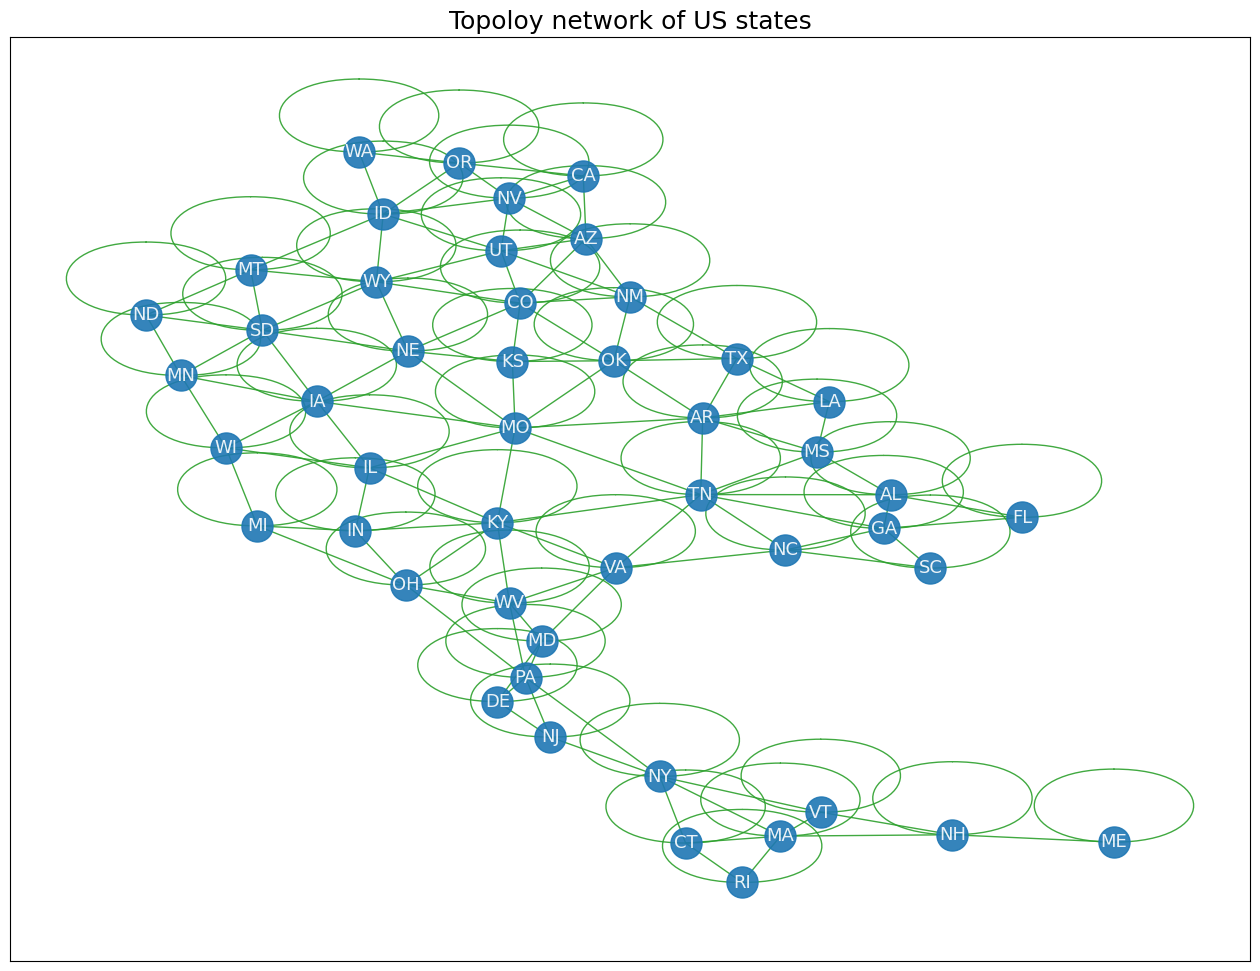

In [681]:
df.to_csv('stateAdjacency.csv', header=False, index=False)
fig = plt.figure("Degree of a random graph", figsize=(16, 12))

# Create a graph from the DataFrame
G = nx.from_pandas_adjacency(df)

# Use the spring layout algorithm to position the nodes
pos = nx.spring_layout(G)

# Draw the graph
#nx.draw(G, pos, with_labels=True, node_size=1000, font_size=14)
nx.draw_networkx(G, pos, with_labels=True, node_size=500, font_size=13, alpha=0.9,edge_color="tab:green", node_color= "tab:blue", font_color="white")

# Show the plot

plt.title('Topoloy network of US states', fontsize=18)

plt.savefig("US state topology.png")
plt.show()

In [682]:
class GraphRepresentation:
    """
    A class to model a graph with its vertices and connecting edges.
    """
    def __init__(self, edges: typing.Tuple[list, list], node_count: int):
        self.edges = edges
        self.node_count = node_count

# Assuming 'df' represents your adjacency matrix DataFrame
adj_matrix = df

# Finding vertices and their corresponding edges
nodes, edges = np.where(adj_matrix == 1)

# Constructing an instance of the GraphRepresentation class
graph_rep = GraphRepresentation(
    edges=(nodes.tolist(), edges.tolist()),
    node_count=adj_matrix.shape[0],
)

# Displaying the graph's details
print(f"Graph has {graph_rep.node_count} vertices, and {len(graph_rep.edges[1])} edges")


Graph has 48 vertices, and 262 edges


### Generating TensorFlow Datasets for Forecasting

We develop datasets tailored for our forecasting task. This task entails predicting future time series values based on past data. Specifically, given a series of values at times t+1, t+2, ..., t+T, the aim is to forecast the values at subsequent times t+T+1, ..., t+T+h. For each time point t, our model processes T input vectors (where T= input sequence length), each representing S states, and predicts h future vectors (where, h= forecast horizon) of the same size S.



In [683]:
consolidated=covidcast.aggregate_signals([   daily_cases_7,
                                           hospitalized_7
                                          ],
                                        dt=None, join_type='left')
new_consolidated= remove_state(consolidated)
geo=new_consolidated["geo_value"].unique()
print("New consoidated dataframe has total: " , len(geo), "states data")

New consoidated dataframe has total:  48 states data


In [684]:
consolidated.columns

Index(['geo_value', 'jhu-csse_confirmed_7dav_incidence_num_0_source',
       'jhu-csse_confirmed_7dav_incidence_num_0_time_type', 'time_value',
       'jhu-csse_confirmed_7dav_incidence_num_0_issue',
       'jhu-csse_confirmed_7dav_incidence_num_0_lag',
       'jhu-csse_confirmed_7dav_incidence_num_0_missing_value',
       'jhu-csse_confirmed_7dav_incidence_num_0_missing_stderr',
       'jhu-csse_confirmed_7dav_incidence_num_0_missing_sample_size',
       'jhu-csse_confirmed_7dav_incidence_num_0_value',
       'jhu-csse_confirmed_7dav_incidence_num_0_stderr',
       'jhu-csse_confirmed_7dav_incidence_num_0_sample_size',
       'hhs_confirmed_admissions_covid_1d_7dav_1_source',
       'hhs_confirmed_admissions_covid_1d_7dav_1_time_type',
       'hhs_confirmed_admissions_covid_1d_7dav_1_issue',
       'hhs_confirmed_admissions_covid_1d_7dav_1_lag',
       'hhs_confirmed_admissions_covid_1d_7dav_1_missing_value',
       'hhs_confirmed_admissions_covid_1d_7dav_1_missing_stderr',
       'hh

In [685]:
new_consolidated.reset_index(drop=True, inplace=True)
#new_consolidated=new_consolidated.drop(['index'], axis=1)
new_consolidated=new_consolidated[['geo_value', 'time_value',

       'jhu-csse_confirmed_7dav_incidence_num_0_value',
        'hhs_confirmed_admissions_covid_1d_7dav_1_value'
    ]]

new_consolidated = new_consolidated.rename(
    columns={
    'jhu-csse_confirmed_7dav_incidence_num_0_value': 'cases_7_jh',
      'hhs_confirmed_admissions_covid_1d_7dav_1_value':'hospitalized_7_hhs',

    })

#print(consolidated[["time_value", "geo_value", "cases", "restaurent_visits", "deaths"]].to_string())
new_consolidated


,geo_value,time_value,cases_7_jh,hospitalized_7_hhs
0,al,2020-06-20,617.000000,NaN
1,ar,2020-06-20,435.285714,0.000000
2,az,2020-06-20,2209.571429,NaN
3,ca,2020-06-20,3824.142857,NaN
4,co,2020-06-20,227.428571,NaN
...,...,...,...,...
40939,vt,2022-10-20,94.714286,10.142857
40940,wa,2022-10-20,665.142857,38.714286
40941,wi,2022-10-20,1021.571429,78.571429
40942,wv,2022-10-20,245.428571,23.428571


In [686]:
merged_dataset=new_consolidated
merged_dataset.columns

Index(['geo_value', 'time_value', 'cases_7_jh', 'hospitalized_7_hhs'], dtype='object')

In [687]:
#merged_dataset['geo_value_x'] = merged_dataset['geo_value'].str.upper()
new_consolidated['geo_value'] = new_consolidated['geo_value'].apply(str.upper)
state_list=["AL", "AZ", "AR", "CA", "CO",
          "CT",  "DE", "FL", "GA", "ID",
          "IA", "IL", "IN", "KS", "KY", "LA",
          "MA", "MD", "ME", "MI", "MN",
          "MO", "MS", "MT", "NC", "ND",
          "NE", "NH", "NJ", "NM",
          "NV", "NY", "OH", "OK", "OR",
          "PA", "RI", "SC", "SD",
          "TN", "TX", "UT", "VA", "VT", "WA",
          "WI", "WV", "WY"]


df_cases_7_jh = merged_dataset.pivot(index='time_value', columns='geo_value', values='cases_7_jh')
df_cases_7_jh=df_cases_7_jh[state_list]
df_cases_7_jh.to_csv('df_cases_7_jh.csv', header=False, index=False)
df_cases_7_jh

df_hospitalized = merged_dataset.pivot(index='time_value', columns='geo_value', values='hospitalized_7_hhs')
df_hospitalized=df_hospitalized[state_list]
df_hospitalized.to_csv('df_hospitalized.csv', header=False, index=False)
df_hospitalized


geo_value,AL,AZ,AR,CA,CO,CT,DE,FL,GA,ID,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
time_value,,,,,,,,,,,,,,,,,,,,,
2020-06-20,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-21,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-22,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-23,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-24,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-16,33.571429,42.142857,19.714286,272.857143,36.857143,68.571429,15.714286,187.571429,75.714286,16.285714,...,10.714286,43.571429,166.571429,20.714286,68.285714,9.285714,44.571429,83.000000,23.428571,3.857143
2022-10-17,33.714286,41.000000,18.571429,267.142857,37.285714,66.428571,16.142857,184.857143,74.857143,16.000000,...,10.714286,43.000000,169.857143,20.142857,64.285714,9.285714,41.857143,80.571429,21.857143,3.571429
2022-10-18,34.857143,43.857143,19.571429,265.571429,35.428571,70.428571,16.285714,183.857143,76.428571,15.142857,...,10.428571,43.857143,169.714286,19.714286,66.428571,10.285714,39.285714,80.428571,22.000000,4.714286


### Policy data
The response to the COVID-19 pandemic in the United States has seen a surge of varied policy
implementations, ranging from physical distancing and mask mandates to the broadening of social
support programs and halting of evictions. The COVID-19 US State Policy (CUSP) ​[https://statepolicies.com/]​database
provides a comprehensive, publicly accessible dataset designed for various stakeholders—including
researchers, policymakers, the media, and the general public to explore the effects of these policies
on public health and health equity. In our modeling, we utilized data on masking mandates and
in-person restaurant operations from the CUSP database, covering the entire timeline of the study.


In [688]:
import pandas as pd

# Load the Excel file
file_path = 'Gym Closures & Reopening.csv'  # Replace with your Excel file name
#sheet_name = 'gym'  # Sheet name

# Read data from the specified sheet
df = pd.read_csv(file_path)

# Convert the DataFrame to a dictionary
closed_gyms_data = {
    'geo_value': df['geo_value'].tolist(),
    'Closed gyms': df['Closed gyms'].tolist(),
    'Reopened gyms': df['Reopened gyms'].tolist(),
    'Closed gyms x2': df['Closed gyms x2'].tolist(),
    'Reopened gyms x2': df['Reopened gyms x2'].tolist()
}

# Print the dictionary to check
print(closed_gyms_data)


{'geo_value': ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Closed gyms': ['3/28/2020', '3/21/2020', '3/20/2020', '3/19/2020', '3/17/2020', '3/16/2020', '3/19/2020', '4/3/2020', '4/3/2020', '3/25/2020', '3/17/2020', '3/21/2020', '3/25/2020', '3/30/2020', '3/18/2020', '3/17/2020', '3/24/2020', '3/16/2020', '3/25/2020', '3/16/2020', '3/17/2020', '4/3/2020', '4/3/2020', '3/20/2020', '3/25/2020', '3/20/2020', '4/3/2020', '3/28/2020', '3/16/2020', '3/19/2020', '3/21/2020', '3/16/2020', '3/17/2020', '4/1/2020', '3/24/2020', '3/21/2020', '3/23/2020', '4/1/2020', '0', '3/23/2020', '3/21/2020', '3/27/2020', '3/25/2020', '3/23/2020', '3/16/2020', '3/25/2020', '3/19/2020', '3/19/2020'], 'Reopened gyms': ['5/11/2020', '5/13/2020', '5/4/2020', '4/15/2021', '

In [689]:
# Load the Excel file
file_path = 'Restaurant Closures & Reopening.csv'  # Replace with your Excel file name
#sheet_name = 'gym'  # Sheet name

# Read data from the specified sheet
df = pd.read_csv(file_path)

# Convert the DataFrame to a dictionary
closed_restaurants_data = {
    'geo_value': df['geo_value'].tolist(),
    'Closed Restaurant': df['Closed restaurants'].tolist(),
    'Reopened Restaurant': df['Reopened restaurants'].tolist(),
    'Closed Restaurant x2': df['Closed restaurants x2'].tolist(),
    'Reopened Restaurant x2': df['Reopened restaurants x2'].tolist(),
    'Closed Restaurant x3': df['Closed restaurants x3'].tolist(),
    'Reopened Restaurant x3': df['Reopened restaurants x3'].tolist()
}

# Print the dictionary to check
print(closed_restaurants_data)

{'geo_value': ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Closed Restaurant': ['3/19/2020', '3/21/2020', '3/20/2020', '3/16/2020', '3/17/2020', '3/16/2020', '3/16/2020', '4/3/2020', '4/3/2020', '3/25/2020', '3/17/2020', '3/16/2020', '3/16/2020', '3/30/2020', '3/16/2020', '3/17/2020', '3/17/2020', '3/16/2020', '3/18/2020', '3/16/2020', '3/17/2020', '3/23/2020', '4/3/2020', '3/20/2020', '3/18/2020', '3/21/2020', '4/3/2020', '3/16/2020', '3/16/2020', '3/20/2020', '3/21/2020', '3/17/2020', '3/16/2020', '4/1/2020', '3/18/2020', '3/18/2020', '3/18/2020', '3/19/2020', '0', '3/24/2020', '3/21/2020', '3/20/2020', '3/26/2020', '3/18/2020', '3/16/2020', '3/18/2020', '3/19/2020', '3/19/2020'], 'Reopened Restaurant': ['5/11/2020', '5/11/2020', '5/11/2020',

In [690]:
# Load the Excel file
file_path = 'Businesses Closures & Reopening.csv'  # Replace with your Excel file name
#sheet_name = 'gym'  # Sheet name

# Read data from the specified sheet
df = pd.read_csv(file_path)

# Convert the DataFrame to a dictionary
closed_businesses_data = {
    'geo_value': df['geo_value'].tolist(),
    'Closed Businesses overnight': df['Closed businesses overnight'].tolist(),
    'Reopened Businesses overnight': df['Reopened businesses overnight'].tolist(),
}
# Print the dictionary to check
print(closed_businesses_data)

{'geo_value': ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Closed Businesses overnight': ['0', '0', '11/19/2020', '11/21/2020', '0', '11/2/2020', '12/14/2020', '0', '0', '0', '11/17/2020', '0', '0', '0', '8/11/2020', '0', '11/6/2020', '11/20/2020', '11/20/2020', '2/1/2021', '11/13/2020', '0', '5/7/2020', '11/20/2020', '12/11/2020', '11/16/2020', '0', '0', '11/10/2020', '10/16/2020', '0', '11/13/2020', '11/19/2020', '11/19/2020', '0', '0', '11/8/2020', '0', '0', '0', '0', '0', '11/15/2020', '11/14/2020', '0', '0', '0', '12/9/2020'], 'Reopened Businesses overnight': ['0', '0', '1/3/2021', '1/25/2021', '0', '5/19/2021', '1/8/2021', '0', '0', '0', '12/10/2020', '0', '0', '0', '5/28/2021', '0', '1/25/2021', '2/1/2021', '2/1/2021', '6/1/2021', '5/7/2

In [691]:
# Load the Excel file
file_path = 'Bars Closures & Reopening.csv'  # Replace with your Excel file name
#sheet_name = 'gym'  # Sheet name

# Read data from the specified sheet
df = pd.read_csv(file_path)

# Convert the DataFrame to a dictionary
closed_bars_data = {
    'geo_value': df['geo_value'].tolist(),
    'Closed Bars': df['Closed bars'].tolist(),
    'Reopened Bars': df['Reopened bars'].tolist(),
    'Closed Bars x2': df['Closed bars x2'].tolist(),
    'Reopened Bars x2': df['Reopened bars x2'].tolist(),
    'Closed Bars x3': df['Closed bars x3'].tolist(),
    'Reopened Bars x3': df['Reopened bars x3'].tolist()
}
# Print the dictionary to check
print(closed_bars_data)

{'geo_value': ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Closed Bars': ['3/19/2020', '3/21/2020', '3/20/2020', '3/16/2020', '3/17/2020', '3/16/2020', '3/16/2020', '3/17/2020', '3/24/2020', '3/25/2020', '3/17/2020', '3/16/2020', '3/16/2020', '3/30/2020', '3/16/2020', '3/17/2020', '3/17/2020', '3/16/2020', '3/18/2020', '3/16/2020', '3/17/2020', '3/23/2020', '4/3/2020', '3/20/2020', '3/17/2020', '3/20/2020', '4/3/2020', '3/16/2020', '3/16/2020', '3/19/2020', '3/21/2020', '3/16/2020', '3/15/2020', '4/1/2020', '3/17/2020', '3/18/2020', '3/17/2020', '3/18/2020', '0', '3/23/2020', '3/21/2020', '3/19/2020', '3/25/2020', '3/17/2020', '3/17/2020', '3/17/2020', '3/18/2020', '3/19/2020'], 'Reopened Bars': ['5/11/2020', '5/16/2020', '5/19/2020', '6/15/202

In [692]:
# Load the Excel file
file_path = 'Movie Closures & Reopening.csv'  # Replace with your Excel file name
#sheet_name = 'gym'  # Sheet name

# Read data from the specified sheet
df = pd.read_csv(file_path)

# Convert the DataFrame to a dictionary
closed_movie_data = {
    'geo_value': df['geo_value'].tolist(),
    'Closed movie theaters': df['Closed movie theaters'].tolist(),
    'Reopened movie theaters': df['Reopened movie theaters'].tolist(),
    'Closed movie theaters x2': df['Closed movie theaters x2'].tolist(),
    'Reopened movie theaters x2': df['Reopened movie theaters x2'].tolist(),
}

# Print the dictionary to check
print(closed_movie_data)

{'geo_value': ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Closed movie theaters': ['3/28/2020', '3/21/2020', '3/20/2020', '3/19/2020', '3/17/2020', '3/16/2020', '3/19/2020', '4/3/2020', '4/3/2020', '3/25/2020', '3/17/2020', '3/21/2020', '3/25/2020', '3/30/2020', '3/18/2020', '3/17/2020', '3/24/2020', '3/16/2020', '3/25/2020', '3/16/2020', '3/17/2020', '4/3/2020', '4/3/2020', '3/20/2020', '3/25/2020', '3/20/2020', '4/9/2020', '3/28/2020', '3/16/2020', '3/19/2020', '3/21/2020', '3/16/2020', '3/17/2020', '4/1/2020', '3/24/2020', '3/21/2020', '3/23/2020', '4/1/2020', '0', '3/23/2020', '4/2/2020', '3/27/2020', '3/25/2020', '3/25/2020', '3/16/2020', '3/25/2020', '3/24/2020', '3/19/2020'], 'Reopened movie theaters': ['5/22/2020', '5/16/2020', '5/18/2

In [693]:
# Load the Excel file
file_path = 'Interstate Travel Quarantines.csv'  # Replace with your Excel file name
#sheet_name = 'gym'  # Sheet name

# Read data from the specified sheet
df = pd.read_csv(file_path)

# Convert the DataFrame to a dictionary
interstate_quarantine_data = {
    'geo_value': df['geo_value'].tolist(),
    'Quarantine mandate start': df['Quarantine mandate start'].tolist(),
    'Quarantine mandate end': df['Quarantine mandate end'].tolist(),

}

# Print the dictionary to check
print(interstate_quarantine_data)

{'geo_value': ['AL', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'ID', 'IA', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA', 'WI', 'WV', 'WY'], 'Quarantine mandate start': ['0', '4/9/2020', '5/5/2020', '0', '0', '6/25/2020', '3/30/2020', '3/24/2020', '0', '4/15/2020', '0', '0', '0', '3/23/2020', '4/2/2020', '0', '3/27/2020', '12/17/2020', '4/3/2020', '0', '0', '0', '0', '3/30/2020', '0', '3/28/2020', '0', '11/15/2020', '0', '7/1/2020', '0', '6/25/2020', '0', '3/29/2020', '0', '11/20/2020', '3/28/2020', '3/27/2020', '0', '0', '3/26/2020', '4/10/2020', '0', '6/8/2020', '0', '0', '3/31/2020', '4/3/2020'], 'Quarantine mandate end': ['0', '5/12/2020', '6/15/2020', '0', '0', '3/19/2021', '6/1/2020', '8/5/2020', '0', '5/16/2020', '0', '0', '0', '0', '5/6/2020', '0', '3/22/2021', '3/12/2021', '5/1/2021', '0', '0', '0', '0', '6/1/2020', 

## Encoding policy data
Function `create_policy_status_df` to create and manipulate dataframes representing the status of various policies (like gym closures, movie theater operations) across different states over a specified time period.

In [694]:
import pandas as pd
import numpy as np

def create_policy_status_df(policy_data, start_prefix, end_prefix):
    # Create a DataFrame
    policy_df = pd.DataFrame(policy_data)

    # Set the 'State Abbreviation' column as the index
    policy_df.set_index('geo_value', inplace=True)

    # Initialize a new DataFrame with dates as rows starting from '2020-06-20'
    dates = pd.date_range(start='2020-06-20', end='2022-10-20', freq='D')
    num_states = len(policy_df)
    policy_status_df = pd.DataFrame(index=dates, columns=policy_df.index)

    # Iterate through the columns in the original DataFrame and fill the new DataFrame with 1 if the policy is active, 0 if not
    for column in policy_df.columns:
        for state in policy_df.index:
            if policy_df.at[state, column] != '0':
                start_date = pd.to_datetime(policy_df.at[state, column], errors='coerce')
                end_date_column = column.replace(start_prefix, end_prefix)
                end_date = pd.to_datetime(policy_df.at[state, end_date_column], errors='coerce')
                if not pd.isnull(start_date) and not pd.isnull(end_date):
                    policy_status_df[state] = np.where((start_date <= policy_status_df.index) & (policy_status_df.index <= end_date), 1, policy_status_df[state])

    # Fill NaN values with 0
    policy_status_df.fillna(0, inplace=True)
    policy_status_df = policy_status_df.rename_axis('time_value')

    return policy_status_df


closed_gyms_status_df = create_policy_status_df(closed_gyms_data, "Closed ", "Reopened ")
movie_theaters_status_df = create_policy_status_df(closed_movie_data, "Closed ", "Reopened ")
#mask_status_df = pd.read_csv("mask_policies.csv")
closed_bars_status_df = create_policy_status_df(closed_bars_data, "Closed ", "Reopened ")
restaurants_status_df = create_policy_status_df(closed_restaurants_data, "Closed ", "Reopened ")
businesses_status_df = create_policy_status_df(closed_businesses_data, "Closed ", "Reopened ")
interstate_quarantine_status_df = create_policy_status_df(interstate_quarantine_data, "Closed ", "Reopened ")


In [695]:
#importing mask related policy (maksing policy encoding had different code for
#policy encoding, which code isn't shown here)

mask_policies_df=(pd.read_csv("mask_policies.csv", index_col=0))
mask_policies_df.index.name = 'time_value'
mask_policies_df.index = pd.to_datetime(mask_policies_df.index)
mask_policies_df

,AL,AZ,AR,CA,CO,CT,DE,FL,GA,ID,...,SD,TN,TX,UT,VA,VT,WA,WI,WV,WY
time_value,,,,,,,,,,,,,,,,,,,,,
2020-06-20,0,1,0,2,0,3,4,1,1,0,...,0,0,0,0,4,0,0,0,0,0
2020-06-21,0,1,0,2,0,3,4,1,1,0,...,0,0,0,0,4,0,0,0,0,0
2020-06-22,0,1,0,2,0,3,4,1,1,0,...,0,0,0,0,4,0,0,0,0,0
2020-06-23,0,1,0,2,0,3,4,1,1,0,...,0,0,0,0,4,0,0,0,0,0
2020-06-24,0,1,0,2,0,3,4,1,1,0,...,0,0,0,0,4,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-15,0,-2,-2,0,0,0,0,-2,-2,0,...,-2,-2,-2,-2,0,0,0,0,0,0
2022-10-16,0,-2,-2,0,0,0,0,-2,-2,0,...,-2,-2,-2,-2,0,0,0,0,0,0
2022-10-17,0,-2,-2,0,0,0,0,-2,-2,0,...,-2,-2,-2,-2,0,0,0,0,0,0


In [696]:
#due to some initial missing hospitalization data in some states, we skipped first 70 data rows from our analuysis

start=70
end=853

#covidcast api data
df_cases=df_cases_7_jh[start:end ]
df_hospitalized=df_hospitalized[start:end]

#policy data
closed_gyms_status_df = closed_gyms_status_df[start:end]
movie_theaters_status_df = movie_theaters_status_df[start:end]
mask_status_df = mask_policies_df[start:end]
closed_bars_status_df = closed_bars_status_df[start:end]
restaurants_status_df = restaurants_status_df[start:end]
businesses_status_df = businesses_status_df[start:end]




In [697]:
#We are resampling our cases data as weekly total cases. For policy, the resampling is done by considering any
#active policy for that specific week, therefore we considered max() for policy resampling.
day_multiplier=1 #a parameter, denoting weekly resampling, which was used in result section later


df_mask_policy=mask_status_df.resample("W").max()
df_mask_policy.columns=mask_status_df.columns

df_closed_gyms_status=closed_gyms_status_df.resample("W").max()
df_closed_gyms_status.columns=closed_gyms_status_df.columns

df_movie_theaters_status = movie_theaters_status_df.resample("W").max()
df_movie_theaters_status.columns = movie_theaters_status_df.columns


df_closed_bars_status = closed_bars_status_df.resample("W").max()
df_closed_bars_status.columns=closed_bars_status_df.columns

df_restaurants_status = restaurants_status_df.resample("W").max()
df_restaurants_status.columns= restaurants_status_df.columns

df_businesses_status = businesses_status_df.resample("W").max()
df_businesses_status.columns= businesses_status_df.columns


df_hospitalized_weekly=df_hospitalized.resample('W').mean()
df_hospitalized_weekly.columns = df_hospitalized.columns


In [698]:
#We considered df_hospitalized_weekly, df_mask_policy, df_restaurants_status for this model

df_multi=np.stack([  df_hospitalized_weekly, df_mask_policy, df_restaurants_status
                    ])

df_multi=np.swapaxes(df_multi,1, 0)
df_multi=np.swapaxes(df_multi,2, 1)
df_multi= np.nan_to_num(df_multi)
df_multi.shape



(113, 48, 3)

In [699]:
#If needed, this model can be converted to univariate
input_features = df_multi.shape[2]
df_multi=df_multi[:,:,:input_features ]
univariate=False
if univariate:
    df_multi=df_multi[:, :, 0]
    df_multi.shape

num_non_binary_features = 1
df_multi.shape

(113, 48, 3)

In [700]:
train_size= 0.75
def preprocessing(data_array: np.ndarray, train_size: float, num_non_binary_features: int):

    num_time_steps = data_array.shape[0]
    num_train = int(num_time_steps * train_size)


    # Split the data into train and test sets
    train_data = data_array[:num_train]
    test_data = data_array[num_train:]

    # Calculate mean and std only for selected non-binary features
    mean = np.mean(train_data[:, :, :num_non_binary_features], axis=0)
    std = np.std(train_data[:, :, :num_non_binary_features], axis=0)

    # Normalize only the selected non-binary features
    train_data[:, :, :num_non_binary_features] = (train_data[:, :, :num_non_binary_features] - mean) / std
    test_data[:, :, :num_non_binary_features] = (test_data[:, :, :num_non_binary_features] - mean) / std

    # Combine train and test data back into total data
    total_data = np.concatenate((train_data, test_data), axis=0)

    return train_data, test_data, total_data, mean, std

# Example usage (assuming df_multi has two features, and you want to normalize both)

train_array, test_array, total_array, mean, std = preprocessing(df_multi, train_size, num_non_binary_features)
print(f"train set size: {train_array.shape}")
print(f"test set size: {test_array.shape}")
print(f"total set size: {total_array.shape}")
print(f"std shape {std.shape} ")
print(f"mean shape {mean.shape} ")


train set size: (84, 48, 3)
test set size: (29, 48, 3)
total set size: (113, 48, 3)
std shape (48, 1) 
mean shape (48, 1) 


In [701]:
#Function create_tf_dataset to create TensorFlow datasets for time series forecasting. It utilizes
#timeseries_dataset_from_array from TensorFlow's Keras API to prepare datasets for training, testing,
#and total data arrays. The function takes parameters like the sequence length of the input
#(input_sequence_length), forecast horizon (forecast_horizon), and batch size, and can handle
#both univariate and multivariate time series data. It allows for both single-step and multi-step
#forecasting (multi_horizon parameter) by adjusting the target sequence length and offset. The datasets
#created by this function are suitable for machine learning models that predict future values in a
#time series based on past observations.

from tensorflow.keras.preprocessing import timeseries_dataset_from_array

batch_size = 1
input_sequence_length = 2
forecast_horizon = 4
multi_horizon = True


def create_tf_dataset(
    data_array: np.ndarray,
    input_sequence_length: int,
    forecast_horizon: int,
    batch_size: int = 1,
    shuffle=True,
    multi_horizon=True,
):

    inputs = timeseries_dataset_from_array(
        data_array[:-forecast_horizon],
        None,
        sequence_length=input_sequence_length,
        shuffle=False,
        batch_size=batch_size,
    )

    target_offset = (
        input_sequence_length
        if multi_horizon
        else input_sequence_length + forecast_horizon - 1
    )
    target_seq_length = forecast_horizon if multi_horizon else 1

    if univariate:
        targets = timeseries_dataset_from_array(
        data_array[target_offset:, :],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    else:
        targets = timeseries_dataset_from_array(
        data_array[target_offset:, :, 0],
        None,
        sequence_length=target_seq_length,
        shuffle=False,
        batch_size=batch_size,
    )

    dataset = tf.data.Dataset.zip((inputs, targets))
    if shuffle:
        dataset = dataset.shuffle(2)

    return dataset.prefetch(2).cache()

train_dataset = create_tf_dataset(
    train_array, input_sequence_length, forecast_horizon, batch_size)


test_dataset = create_tf_dataset(
    test_array,
    input_sequence_length,
    forecast_horizon,
    batch_size=test_array.shape[0],
    shuffle=False,
    multi_horizon=multi_horizon,
)



# GCN_LSTM

### Graph convolution layer

This Python class, GraphConvolutionLayer, defines a custom layer for use in neural networks that work with graph-structured data. It's implemented using TensorFlow and the Keras API. Here's a brief overview of its functionality:

Initialization '(__init__)': This method sets up the layer. Key parameters include:

> `input_features` and `output_features`: Define the size of the input and output feature vectors.
> `graph_structure`: An object of type GraphRepresentation that contains information about the graph's structure (like edges and node count).
> `aggregation_method`: Determines how neighbor features are aggregated (e.g., sum, mean, max).
> `combine_method`: Specifies how the features of a node and its aggregated neighbors are combined (e.g., concatenation, addition).
> `activation_func`: The activation function to be applied.
The layer's weights are initialized using the GlorotUniform method.
> Neighbor Aggregation (`aggregate_neighbors`): This method aggregates the features of neighboring nodes using the specified aggregation method.

Vertex Feature Computation (`compute_vertex_features`): Computes the features of each vertex (node) by applying a linear transformation (matrix multiplication with layer_weights).

Message Aggregation (`compute_message_aggregation`): This method computes aggregated messages from neighbors, which involves gathering neighbor features and applying the aggregation method.

Feature Combination (`combine_features`): Combines the vertex features with the aggregated messages. The method of combination is determined by combine_method, and the result is passed through an activation function.

Layer Call (call): This is the main method called during the forward pass of the network. It computes the vertex features, aggregates messages, and combines these features as per the layer's configuration.

In [702]:
class GraphConvolutionLayer(layers.Layer):
    def __init__(
        self,
        input_features,
        output_features,
        graph_structure: GraphRepresentation,
        aggregation_method="max",
        combine_method="concat",
        activation_func: typing.Optional[str] = "tanh",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.graph_structure = graph_structure
        self.aggregation_method = aggregation_method
        self.combine_method = combine_method
        self.layer_weights = tf.Variable(
            initial_value=keras.initializers.GlorotUniform()(
                shape=(self.input_features, self.output_features), dtype="float32"
            ),
            trainable=True,
        )
        self.activation_layer = layers.Activation(activation_func)

    def aggregate_neighbors(self, neighbor_features: tf.Tensor):
        aggregate_functions = {
            "sum": tf.math.unsorted_segment_sum,
            "mean": tf.math.unsorted_segment_mean,
            "max": tf.math.unsorted_segment_max,
        }.get(self.aggregation_method)

        if aggregate_functions:
            return aggregate_functions(
                neighbor_features,
                self.graph_structure.edges[0],
                num_segments=self.graph_structure.node_count,
            )

        raise ValueError(f"Unsupported aggregation method: {self.aggregation_method}")

    def compute_vertex_features(self, node_features: tf.Tensor):
        return tf.matmul(node_features, self.layer_weights)

    def compute_message_aggregation(self, node_features: tf.Tensor):
        neighbor_features = tf.gather(node_features, self.graph_structure.edges[1])
        aggregated_neighbors = self.aggregate_neighbors(neighbor_features)
        return tf.matmul(aggregated_neighbors, self.layer_weights)

    def combine_features(self, vertex_features: tf.Tensor, aggregated_messages: tf.Tensor):
        if self.combine_method == "concat":
            combined_features = tf.concat([vertex_features, aggregated_messages], axis=-1)
        elif self.combine_method == "add":
            combined_features = vertex_features + aggregated_messages
        else:
            raise ValueError(f"Unsupported combination method: {self.combine_method}.")
        return self.activation_layer(combined_features)

    def call(self, node_features: tf.Tensor):
        vertex_features = self.compute_vertex_features(node_features)
        aggregated_messages = self.compute_message_aggregation(node_features)
        return self.combine_features(vertex_features, aggregated_messages)



By applying the graph convolution layer to the input tensor, we get another tensor
containing the nodes' representations over time (another 4D tensor). For each time
step, a node's representation is informed by the information from its neighbors.

To make good forecasts, however, we need not only information from the neighbors
but also we need to process the information over time. To this end, we can pass each
node's tensor through a recurrent layer. The `GraphLSTMConvLayer` layer below, first applies  graph convolution layer to the inputs and then passes the results through a
`LSTM` layer.

In [703]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

In [704]:
## Definition of LSTM with Graph Convolutional Network
#The GraphLSTMConvLayer class in this Python code defines a custom neural
#network layer that integrates Graph Convolutional Networks (GCNs) with
#Long Short-Term Memory (LSTM) networks.
class GraphLSTMConvLayer(layers.Layer):
    def __init__(
        self,
        input_dim_list,
        output_features,
        lstm_size: int,
        input_sequence_length: int,
        output_sequence_length: int,
        graph_representation: GraphRepresentation,
        graph_convolution_settings: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Initialize Graph Convolution layers
        self.graph_convolution_layers = []
        for index in range(0, len(input_dim_list) - 1, 2):
            self.graph_convolution_layers.append(GraphConvolutionLayer(
                input_dim_list[index],
                input_dim_list[index + 1],
                graph_representation,
                **graph_convolution_settings
            ))

        # LSTM layers configuration
        self.lstm_layer_1 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.lstm_layer_2 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.lstm_layer_3 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.final_lstm_layer = layers.LSTM(lstm_size)

        # Output layer
        self.output_dense_layer = layers.Dense(output_sequence_length)
        self.in_seq_length, self.out_seq_length = input_sequence_length, output_sequence_length

    def call(self, input_tensor):
        # Reshaping the input for processing
        reshaped_input = tf.transpose(input_tensor, [2, 0, 1, 3])

        # Applying Graph Convolution Layers
        for graph_layer in self.graph_convolution_layers:
            reshaped_input = graph_layer(reshaped_input)

        # Preparing input for LSTM layers
        lstm_input_shape = tf.shape(reshaped_input)
        nodes, batch_size, seq_len = lstm_input_shape[0], lstm_input_shape[1], lstm_input_shape[2]
        lstm_input = tf.reshape(reshaped_input, (batch_size * nodes, seq_len, input_dim_list[-1]))

        # Processing through LSTM layers
        lstm_output = self.lstm_layer_1(lstm_input)
        lstm_output = self.lstm_layer_2(lstm_output)
        lstm_output = self.lstm_layer_3(lstm_output)
        lstm_output = self.final_lstm_layer(lstm_output)

        # Final dense layer for output
        final_output = self.output_dense_layer(lstm_output)

        # Reshaping to the desired output format
        reshaped_output = tf.reshape(final_output, (nodes, batch_size, self.out_seq_length))
        return tf.transpose(reshaped_output, [1, 2, 0])  # Final shape: (batch_size, output_sequence_length, num_nodes)


## GCN_LSTM Model training

In [798]:
###testing multi GCN

#input_dim_list should be of shape [initial num of featues, a, 2a, b, 2b, .....] in this sereis.
#a and b doens't need to have any specific relationship

input_dim_list = [input_features, 8, 16]

#`input_features_list`: A list specifying the dimensions of features for the GCN
#layers (e.g., [in_feat, 8, 16]). This implies the network will have multiple GCN
#layers with increasing feature dimensions.


epochs = 500
input_sequence_length = 2
output_features = 6
lstm_size = 24
graph_convolution_settings = {
    "aggregation_method": "mean",
    "combine_method": "concat",
    "activation_func": "tanh",
}

GCN_LSTM = GraphLSTMConvLayer(
    input_dim_list,
    output_features,
    lstm_size,
    input_sequence_length,
    forecast_horizon,
    graph_rep,
    graph_convolution_settings,
)
inputs = layers.Input((input_sequence_length, graph_rep.node_count, input_features))
outputs = GCN_LSTM(inputs)

def custom_loss(y_true, y_pred):
    error = y_pred - y_true
    overestimate_penalty = tf.where(error > 0, 1.6 * error, error)  # Apply a penalty factor for overestimation
    return tf.reduce_mean(tf.abs(overestimate_penalty))

gcn_lstm_model = keras.models.Model(inputs, outputs)
gcn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    #loss=keras.losses.MeanAbsoluteError(),
    loss=custom_loss,
    #loss=keras.losses.Huber(),
    metrics=["mae"]
)

for epoch in range(epochs):
    history = gcn_lstm_model.fit(
        train_dataset,
        epochs=1,
        verbose=False,
        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
    )

    if (epoch + 1) % 10 == 0:
        loss = history.history['loss'][0]
        print(f"Epoch {epoch + 1}: Loss = {loss}")



Epoch 10: Loss = 0.7642315030097961
Epoch 20: Loss = 0.7071743607521057
Epoch 30: Loss = 0.6925694346427917
Epoch 40: Loss = 0.6815495491027832
Epoch 50: Loss = 0.6729687452316284
Epoch 60: Loss = 0.6669832468032837
Epoch 70: Loss = 0.6624683141708374
Epoch 80: Loss = 0.6589758396148682
Epoch 90: Loss = 0.6557903289794922
Epoch 100: Loss = 0.6525368690490723
Epoch 110: Loss = 0.649319589138031
Epoch 120: Loss = 0.6459552049636841
Epoch 130: Loss = 0.6423490643501282
Epoch 140: Loss = 0.638201117515564
Epoch 150: Loss = 0.6331191062927246
Epoch 160: Loss = 0.6265577077865601
Epoch 170: Loss = 0.6173093914985657
Epoch 180: Loss = 0.6022173166275024
Epoch 190: Loss = 0.5783160924911499
Epoch 200: Loss = 0.5561100244522095
Epoch 210: Loss = 0.5367328524589539
Epoch 220: Loss = 0.519097089767456
Epoch 230: Loss = 0.49921464920043945
Epoch 240: Loss = 0.4730653464794159
Epoch 250: Loss = 0.4422335624694824
Epoch 260: Loss = 0.414143443107605
Epoch 270: Loss = 0.3950253129005432
Epoch 280: Lo

# GAT_LSTM

In [799]:
class GraphAttentionLayer(layers.Layer):
    def __init__(
        self,
        input_features,
        output_features,
        graph_structure: GraphRepresentation,
        num_heads=1,
        activation_func: typing.Optional[str] = "tanh",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.graph_structure = graph_structure
        self.num_heads = num_heads

        self.attention_weights = [self.add_weight(
            shape=(self.input_features, self.output_features),
            initializer='glorot_uniform',
            trainable=True,
            name=f'weight_{i}'
        ) for i in range(self.num_heads)]

        self.attention_a = [self.add_weight(
            shape=(2 * self.output_features, 1),
            initializer='glorot_uniform',
            trainable=True,
            name=f'attention_a_{i}'
        ) for i in range(self.num_heads)]

        self.leaky_relu = layers.LeakyReLU(alpha=0.2)
        self.activation = layers.Activation(activation_func)

    def call(self, inputs):
        outputs = []
        for head in range(self.num_heads):
            Wh = tf.matmul(inputs, self.attention_weights[head])  # (N, out_features)

            # Prepare indices for edge-wise concatenation
            edge_indices = self.graph_structure.edges
            Wh_i = tf.gather(Wh, edge_indices[0])  # Source node features
            Wh_j = tf.gather(Wh, edge_indices[1])  # Target node features

            # Concatenate and compute attention coefficients
            Wh_ij = tf.concat([Wh_i, Wh_j], axis=-1)  # (E, 2*out_features)
            e_ij = self.leaky_relu(tf.matmul(Wh_ij, self.attention_a[head]))  # (E, 1)

            # Normalize attention scores
            attention_scores = tf.squeeze(e_ij, axis=-1)
            attention_scores = tf.exp(attention_scores)
            # Sum of attention scores for each target node
            segment_sum = tf.math.unsorted_segment_sum(
                attention_scores,
                edge_indices[0],
                num_segments=self.graph_structure.node_count
            )
            attention_coefficients = attention_scores / tf.gather(segment_sum, edge_indices[0])

            # Compute aggregated features
            neighbor_features = Wh_j * tf.expand_dims(attention_coefficients, axis=-1)
            aggregated_features = tf.math.unsorted_segment_sum(
                neighbor_features,
                edge_indices[0],
                num_segments=self.graph_structure.node_count
            )

            outputs.append(aggregated_features)

        # Concatenate outputs from all heads
        if self.num_heads > 1:
            output = tf.concat(outputs, axis=-1)
        else:
            output = outputs[0]

        return self.activation(output)

class GraphLSTMConvLayer_GAT(layers.Layer):
    def __init__(
        self,
        input_dim_list,
        output_features,
        lstm_size: int,
        input_sequence_length: int,
        output_sequence_length: int,
        graph_representation: GraphRepresentation,
        graph_attention_settings: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Initialize Graph Attention layers
        self.graph_attention_layers = []
        for index in range(0, len(input_dim_list) - 1, 2):
            self.graph_attention_layers.append(GraphAttentionLayer(
                input_dim_list[index],
                input_dim_list[index + 1],
                graph_representation,
                **graph_attention_settings
            ))

        # LSTM layers configuration
        self.lstm_layer_1 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.lstm_layer_2 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.lstm_layer_3 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.final_lstm_layer = layers.LSTM(lstm_size)

        # Output layer
        self.output_dense_layer = layers.Dense(output_sequence_length)
        self.in_seq_length, self.out_seq_length = input_sequence_length, output_sequence_length

    def call(self, input_tensor):
        # Reshaping the input for processing
        reshaped_input = tf.transpose(input_tensor, [2, 0, 1, 3])

        # Applying Graph Attention Layers
        for graph_layer in self.graph_attention_layers:
            reshaped_input = graph_layer(reshaped_input)

        # Preparing input for LSTM layers
        lstm_input_shape = tf.shape(reshaped_input)
        nodes, batch_size, seq_len = lstm_input_shape[0], lstm_input_shape[1], lstm_input_shape[2]
        lstm_input = tf.reshape(reshaped_input, (batch_size * nodes, seq_len, input_dim_list[-1]))

        # Processing through LSTM layers
        lstm_output = self.lstm_layer_1(lstm_input)
        lstm_output = self.lstm_layer_2(lstm_output)
        lstm_output = self.lstm_layer_3(lstm_output)
        lstm_output = self.final_lstm_layer(lstm_output)

        # Final dense layer for output
        final_output = self.output_dense_layer(lstm_output)

        # Reshaping to the desired output format
        reshaped_output = tf.reshape(final_output, (nodes, batch_size, self.out_seq_length))
        return tf.transpose(reshaped_output, [1, 2, 0])  # Final shape: (batch_size, output_sequence_length, num_nodes)

graph_attention_settings = {
    "num_heads": 2,
    "activation_func": "tanh",
}

GAT_LSTM = GraphLSTMConvLayer_GAT(
    input_dim_list,
    output_features,
    lstm_size,
    input_sequence_length,
    forecast_horizon,
    graph_rep,
    graph_attention_settings,
)
inputs = layers.Input((input_sequence_length, graph_rep.node_count, input_features))
outputs = GAT_LSTM(inputs)

def custom_loss(y_true, y_pred):
    error = y_pred - y_true
    overestimate_penalty = tf.where(error > 0, 1.5 * error, error)  # Apply a penalty factor for overestimation
    return tf.reduce_mean(tf.abs(overestimate_penalty))
    
gat_lstm_model = keras.models.Model(inputs, outputs)
gat_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    #loss=keras.losses.MeanAbsoluteError(),
    loss=custom_loss,
    metrics=["mae"]
)

for epoch in range(epochs):
    history = gat_lstm_model.fit(
        train_dataset,
        epochs=1,
        verbose=False,
        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=10)],
    )

    if (epoch + 1) % 10 == 0:
        loss = history.history['loss'][0]
        print(f"Epoch {epoch + 1}: Loss = {loss}")


Epoch 10: Loss = 0.7509726285934448
Epoch 20: Loss = 0.7014318704605103
Epoch 30: Loss = 0.689328134059906
Epoch 40: Loss = 0.6800171732902527
Epoch 50: Loss = 0.6723976135253906
Epoch 60: Loss = 0.6660372614860535
Epoch 70: Loss = 0.6616626381874084
Epoch 80: Loss = 0.6582833528518677
Epoch 90: Loss = 0.6552227139472961
Epoch 100: Loss = 0.652195394039154
Epoch 110: Loss = 0.6490617394447327
Epoch 120: Loss = 0.6457328200340271
Epoch 130: Loss = 0.6420400142669678
Epoch 140: Loss = 0.6377657055854797
Epoch 150: Loss = 0.6326012015342712
Epoch 160: Loss = 0.6256370544433594
Epoch 170: Loss = 0.6148867607116699
Epoch 180: Loss = 0.5960696935653687
Epoch 190: Loss = 0.5693762302398682
Epoch 200: Loss = 0.5425695180892944
Epoch 210: Loss = 0.5144128799438477
Epoch 220: Loss = 0.4931629002094269
Epoch 230: Loss = 0.4795418381690979
Epoch 240: Loss = 0.46957364678382874
Epoch 250: Loss = 0.46121159195899963
Epoch 260: Loss = 0.4537867307662964
Epoch 270: Loss = 0.44671866297721863
Epoch 280

# GTN_LSTM

In [829]:
from tensorflow.keras import regularizers

class GraphTransformerLayer(layers.Layer):
    def __init__(
        self,
        input_features,
        output_features,
        graph_structure: GraphRepresentation,
        num_heads: int = 8,
        activation_func: typing.Optional[str] = "tanh",
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.input_features = input_features
        self.output_features = output_features
        self.graph_structure = graph_structure
        self.num_heads = num_heads

        self.q_dense = layers.Dense(output_features * num_heads)
        self.k_dense = layers.Dense(output_features * num_heads)
        self.v_dense = layers.Dense(output_features * num_heads)
        self.out_dense = layers.Dense(output_features)

        self.activation_layer = layers.Activation(activation_func)

    def attention(self, q, k, v):
        attn_scores = tf.matmul(q, k, transpose_b=True)
        attn_scores = tf.nn.softmax(attn_scores, axis=-1)
        attn_output = tf.matmul(attn_scores, v)
        return attn_output

    def call(self, node_features: tf.Tensor):
        q = self.q_dense(node_features)
        k = self.k_dense(node_features)
        v = self.v_dense(node_features)

        q = tf.concat(tf.split(q, self.num_heads, axis=-1), axis=0)
        k = tf.concat(tf.split(k, self.num_heads, axis=-1), axis=0)
        v = tf.concat(tf.split(v, self.num_heads, axis=-1), axis=0)

        attn_output = self.attention(q, k, v)
        attn_output = tf.concat(tf.split(attn_output, self.num_heads, axis=0), axis=-1)
        output = self.out_dense(attn_output)

        return self.activation_layer(output)


class GraphLSTMTransformerLayer(layers.Layer):
    def __init__(
        self,
        input_dim_list,
        output_features,
        lstm_size: int,
        input_sequence_length: int,
        output_sequence_length: int,
        graph_representation: GraphRepresentation,
        transformer_settings: typing.Optional[dict] = None,
        **kwargs,
    ):
        super().__init__(**kwargs)

        # Initialize Graph Transformer layers
        self.graph_transformer_layers = []
        for index in range(0, len(input_dim_list) - 1, 2):
            self.graph_transformer_layers.append(GraphTransformerLayer(
                input_dim_list[index],
                input_dim_list[index + 1],
                graph_representation,
                **transformer_settings
            ))

        # LSTM layers configuration
        self.lstm_layer_1 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.lstm_layer_2 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.lstm_layer_3 = layers.LSTM(lstm_size, activation="tanh", return_sequences=True)
        self.final_lstm_layer = layers.LSTM(lstm_size)

        # Output layer
        self.output_dense_layer = layers.Dense(output_sequence_length)
        self.in_seq_length, self.out_seq_length = input_sequence_length, output_sequence_length

    def call(self, input_tensor):
        # Reshaping the input for processing
        reshaped_input = tf.transpose(input_tensor, [2, 0, 1, 3])

        # Applying Graph Transformer Layers
        for transformer_layer in self.graph_transformer_layers:
            reshaped_input = transformer_layer(reshaped_input)

        # Prepare input for LSTM layers
        lstm_input_shape = tf.shape(reshaped_input)
        nodes, batch_size, seq_len, features = lstm_input_shape[0], lstm_input_shape[1], lstm_input_shape[2], lstm_input_shape[3]
        lstm_input = tf.reshape(reshaped_input, (batch_size * nodes, seq_len, features))

        # Process through LSTM layers
        lstm_output = self.lstm_layer_1(lstm_input)
        lstm_output = self.lstm_layer_2(lstm_output)
        lstm_output = self.lstm_layer_3(lstm_output)
        lstm_output = self.final_lstm_layer(lstm_output)

        # Final dense layer for output
        final_output = self.output_dense_layer(lstm_output)

        # Reshaping to the desired output format
        reshaped_output = tf.reshape(final_output, (nodes, batch_size, self.out_seq_length))
        return tf.transpose(reshaped_output, [1, 2, 0])  # Final shape: (batch_size, output_sequence_length, num_nodes)

# Testing the modified GTN-LSTM

input_dim_list = [input_features, 8, 16]
epochs=500
input_sequence_length = 2
output_features = 6
lstm_size = 24
transformer_settings = {
    "num_heads": 8,
    "activation_func": "tanh",
}

GTN = GraphLSTMTransformerLayer(
    input_dim_list,
    output_features,
    lstm_size,
    input_sequence_length,
    forecast_horizon,
    graph_rep,
    transformer_settings,
)
inputs = layers.Input((input_sequence_length, graph_rep.node_count, input_features))
outputs = GTN(inputs)

    
gtn_lstm_model = keras.models.Model(inputs, outputs)
gtn_lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss=keras.losses.MeanAbsoluteError(),
    #loss=keras.losses.Huber(),
    #loss=custom_loss,
    metrics=["mae"]
)

for epoch in range(epochs):
    history = gtn_lstm_model.fit(
        train_dataset,
        epochs=1,
        verbose=False,
        callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=20)],
    )

    if (epoch + 1) % 10 == 0:
        loss = history.history['loss'][0]
        print(f"Epoch {epoch + 1}: Loss = {loss}")


Epoch 10: Loss = 0.559552013874054
Epoch 20: Loss = 0.5444815158843994
Epoch 30: Loss = 0.537426769733429
Epoch 40: Loss = 0.5328977704048157
Epoch 50: Loss = 0.529708981513977
Epoch 60: Loss = 0.5270364284515381
Epoch 70: Loss = 0.5246641039848328
Epoch 80: Loss = 0.5227794647216797
Epoch 90: Loss = 0.5212385058403015
Epoch 100: Loss = 0.5198397040367126
Epoch 110: Loss = 0.5186891555786133
Epoch 120: Loss = 0.51749587059021
Epoch 130: Loss = 0.5164139270782471
Epoch 140: Loss = 0.5154449343681335
Epoch 150: Loss = 0.5145197510719299
Epoch 160: Loss = 0.5136492848396301
Epoch 170: Loss = 0.5128458142280579
Epoch 180: Loss = 0.512024998664856
Epoch 190: Loss = 0.5111700892448425
Epoch 200: Loss = 0.5104290246963501
Epoch 210: Loss = 0.5096629858016968
Epoch 220: Loss = 0.5088889002799988
Epoch 230: Loss = 0.5082650780677795
Epoch 240: Loss = 0.5074853897094727
Epoch 250: Loss = 0.5066542625427246
Epoch 260: Loss = 0.5058743357658386
Epoch 270: Loss = 0.5050079822540283
Epoch 280: Loss 

## Making forecasts on test set



#saving the model for reproducibility of result
np.save('std.npy', std)
np.save('mean.npy', mean)

In [832]:
gcn_lstm_model.save('gcn_lstm_model')
gat_lstm_model.save('gat_lstm_model')
gtn_model.save('gtn_lstm_model')

INFO:tensorflow:Assets written to: gcn_lstm_model\assets


INFO:tensorflow:Assets written to: gcn_lstm_model\assets


INFO:tensorflow:Assets written to: gat_lstm_model\assets


INFO:tensorflow:Assets written to: gat_lstm_model\assets


INFO:tensorflow:Assets written to: gtn_lstm_model\assets


INFO:tensorflow:Assets written to: gtn_lstm_model\assets


#in case we want to save the new prediction
x_test, y = next(test_dataset.as_numpy_iterator())
np.save('x_test.npy', x_test)
np.save('y.npy', y)

In [834]:
x_test, y = next(test_dataset.as_numpy_iterator())

In [835]:
#for evaluation of model performance (new run) we do import the saved prediction data
x_test = np.load('x_test.npy')
y = np.load('y.npy')
print("x_test.shape", x_test.shape)
print("y.shape", y.shape)
print('mean.shape', mean.shape)
print('std.shape', std.shape)

x_test.shape (24, 2, 48, 3)
y.shape (24, 4, 48)
mean.shape (48, 1)
std.shape (48, 1)


In [836]:
y_pred_gcn_lstm = gcn_lstm_model.predict(x_test)
y_pred_gat_lstm=gat_lstm_model.predict(x_test)
y_pred_gtn_lstm=gtn_lstm_model.predict(x_test)

np.save('y_pred_gcn_lstm.npy', y_pred_gcn_lstm)
np.save('y_pred_gat_lstm.npy', y_pred_gat_lstm)
np.save('y_pred_gtn_lstm.npy', y_pred_gtn_lstm)

y_pred_gcn_lstm= np.load('y_pred_gcn_lstm.npy')
y_pred_gat_lstm=np.load('y_pred_gat_lstm.npy')
y_pred_gtn_lstm=np.load('y_pred_gtn_lstm.npy')

1/1 [==============================] - 2s 2s/step


In [837]:
def denormalization_all(x_test, y, y_pred, mean, std):
        x_test=x_test[:, :, :, 0]* std[:,0] +mean[:,0]
        #x_test_shape=(timestep, input_sequence_length, states)
        y=y*std[:, 0]+mean[:, 0]
        y_pred=y_pred*std[:,0]+mean[:,0]
        return x_test, y, y_pred

In [838]:
def denormalization(y_pred, mean, std):
    y_pred=y_pred*std[:, 0]+mean[:,0]
    return y_pred

In [839]:
x_test, y, y_pred_gcn_lstm=denormalization_all(x_test, y, y_pred_gcn_lstm, mean, std)
y_pred_gat_lstm=denormalization(y_pred_gat_lstm, mean, std)
y_pred_gtn_lstm=denormalization(y_pred_gtn_lstm, mean, std)

# visualize GCN_LSTM prediction

# visualize GAT_LSTM prediction

# visualize GTN prediction

# Visualization of MAE

In [841]:
#This Python script uses libraries such as NumPy, Pandas, Matplotlib, and Seaborn to analyze and
#visualize the Mean Absolute Error (MAE) of a forecasting model across different time horizons and
#weeks. The script calculates the MAE for each state in each week and for each forecasting horizon.
#It then organizes these values into a DataFrame for easy visualization. A boxplot is generated using
#Seaborn to display the distribution of MAE values across different weeks and forecasting horizons.

def plot_mae(y, y_pred, std, mean, model_name):

    total_weeks = y_pred.shape[0]
    forecast_horizon = y_pred.shape[1]
    num_states = y_pred.shape[2]  # Assuming the third dimension is the number of states

    # Prepare data for seaborn boxplot
    mae_values = []
    weeks = []
    horizons = []

    for horizon in range(forecast_horizon):
        for week in range(total_weeks):
            for state in range(num_states):
                # Calculate MAE for each state
                model_mae = np.mean(np.abs(y_pred[week, horizon, state] - y[week, horizon, state]))
                mae_values.append(model_mae)
                weeks.append(f"Week {week + 1}")
                horizons.append(f"Horizon {horizon + 1}")

    # Creating a DataFrame
    data = pd.DataFrame({'Week': weeks, 'Horizon': horizons, 'MAE': mae_values})

    # Plotting
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='Week', y='MAE', hue='Horizon', data=data, palette="Set3", showfliers=False)
    plt.title(f'MAE Values Across Different Forecasting Horizons for {model_name} model', fontsize=14)
    
    plt.xlabel('Week', fontsize=14)
    plt.ylabel('MAE', fontsize=14)
    plt.legend(title='Forecasting Horizon', fontsize=12)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.ylim(top=175)
    plt.tight_layout()
    plt.savefig(f"maeplot_model {model_name}.png", dpi=600)
    plt.show()


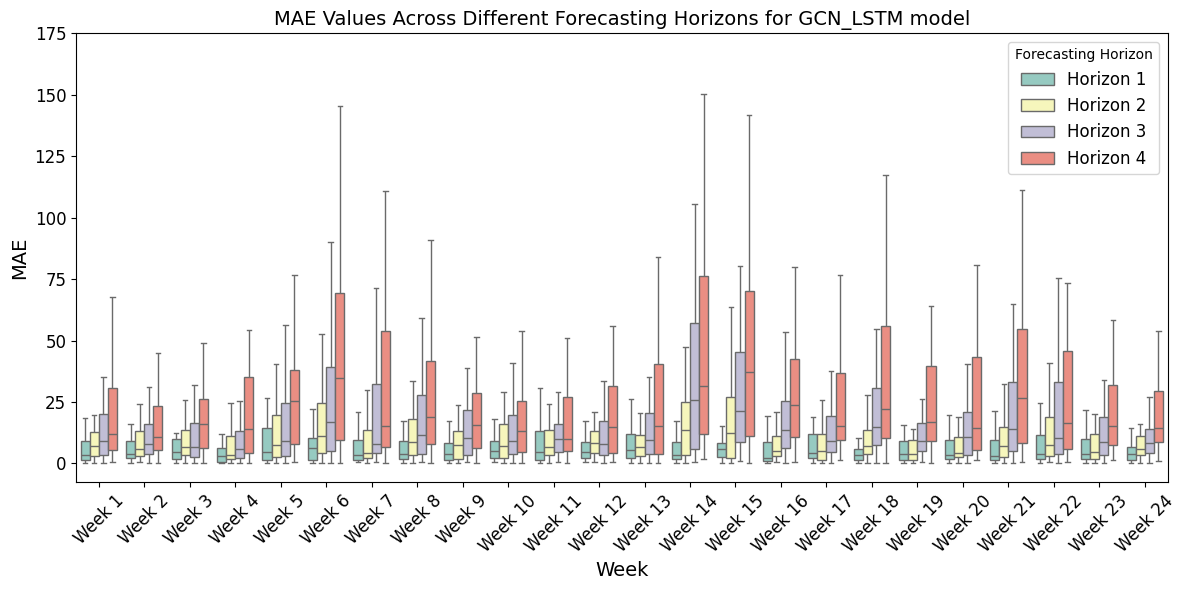

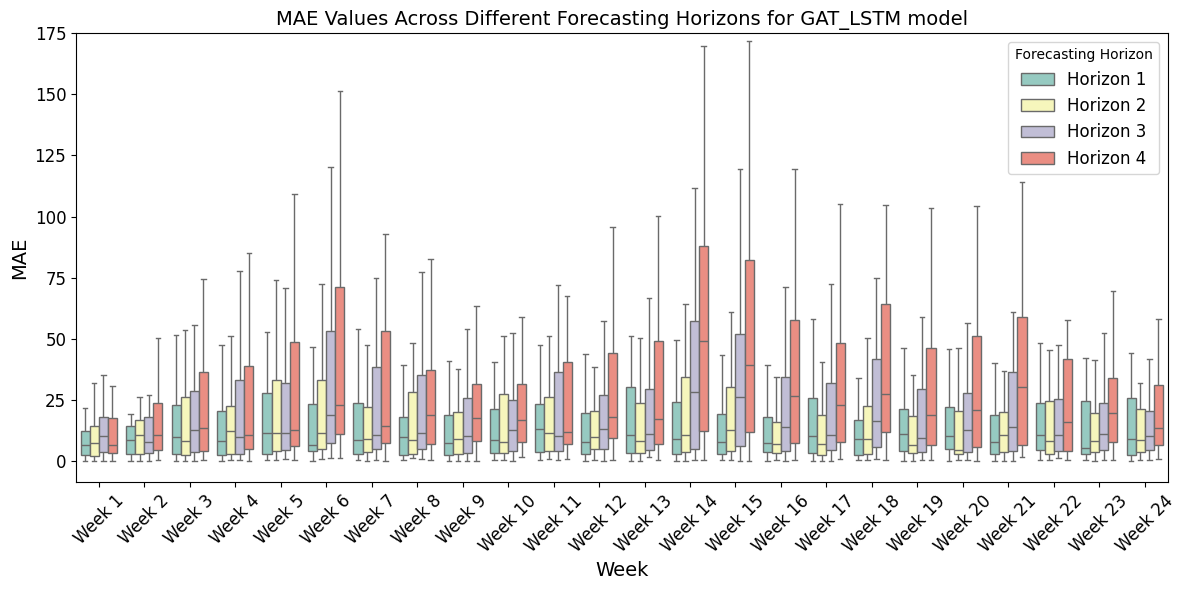

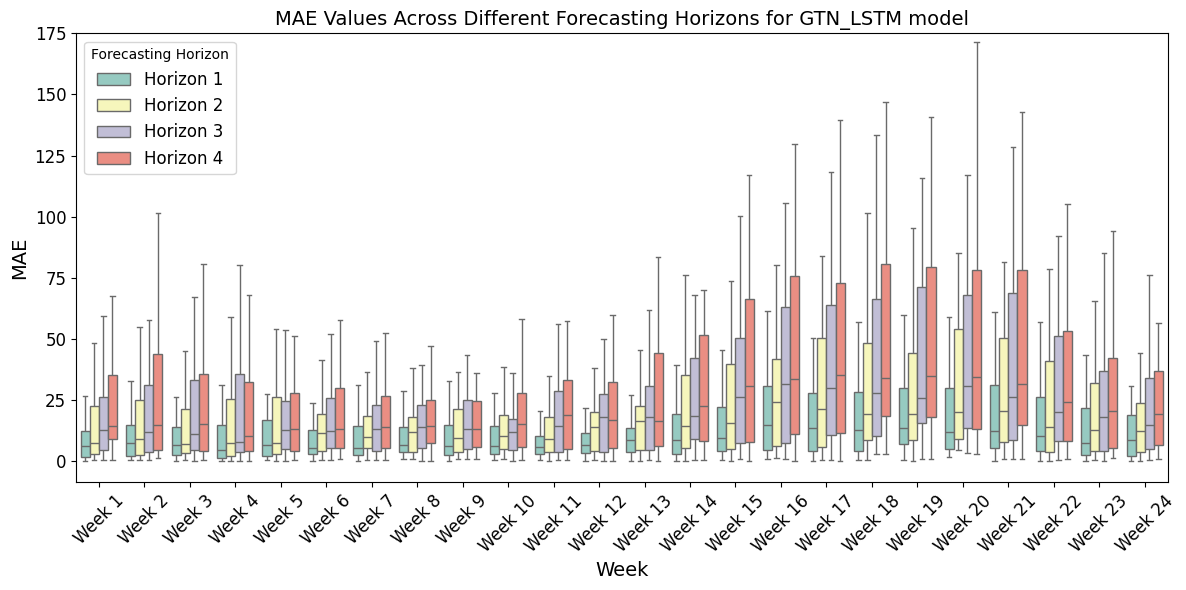

In [842]:
plot_mae(y, y_pred_gcn_lstm, std, mean, model_name='GCN_LSTM')
plot_mae(y, y_pred_gat_lstm, std, mean, model_name='GAT_LSTM')
plot_mae(y, y_pred_gtn_lstm, std, mean, model_name='GTN_LSTM')

### Model Evaluation (Covid-19 Forecast Hub models)
Code to process and analyze COVID-19 forecast data. Here in each code section, we import the different covid-19 forecast hub reported models and prepare the dataframe for comparative visualization.
It defines a set of  state FIPS codes, specifies forecast horizons (7, 14, 21, and 28 days ahead for increased  hospitalizations), and sets a directory for data retrieval. The script iterates through each model's directory within a base directory, filtering and extracting relevant forecast data from CSV files
based on certain conditions (like matching forecast horizons, state codes, quantile, and date range
between '2022-04-18' and '2022-09-26'). The extracted data from all models are then combined into a
single DataFrame

In [843]:
#UT-osiris model data

import os
import pandas as pd
import numpy as np


# Define the parameters
state_FIPS = {
    "AL": "01", "AZ": "04", "AR": "05", "CA": "06", "CO": "08",
    "CT": "09", "DE": "10", "FL": "12", "GA": "13", "ID": "16",
    "IA": "19", "IL": "17", "IN": "18", "KS": "20", "KY": "21",
    "LA": "22", "MA": "25", "MD": "24", "ME": "23", "MI": "26",
    "MN": "27", "MO": "29", "MS": "28", "MT": "30", "NC": "37",
    "ND": "38", "NE": "31", "NH": "33", "NJ": "34", "NM": "35",
    "NV": "32", "NY": "36", "OH": "39", "OK": "40", "OR": "41",
    "PA": "42", "RI": "44", "SC": "45", "SD": "46", "TN": "47",
    "TX": "48", "UT": "49", "VA": "51", "VT": "50", "WA": "53",
    "WI": "55", "WV": "54", "WY": "56"
}
states = list(state_FIPS.values())
horizons = ['7 day ahead inc hosp', '14 day ahead inc hosp', '21 day ahead inc hosp', '28 day ahead inc hosp']

# Define the forecast horizons variable
forecast_horizons = horizons

base_dir = './covid19-forecast-hub/data-processed_UT/'

# Loop through each model's directory and extract the data
all_forecasts = []
for model_dir in os.listdir(base_dir):
    model_path = os.path.join(base_dir, model_dir)
    if os.path.isdir(model_path):
        for forecast_file in os.listdir(model_path):
            if forecast_file.endswith('.csv'):
                forecast_df = pd.read_csv(os.path.join(model_path, forecast_file))
                mask = (
                    forecast_df['target'].isin(forecast_horizons) &
                    forecast_df['location'].isin(states) &
                    (forecast_df['quantile'] == 0.5) &
                    (forecast_df['forecast_date'] >= '2022-04-18') &
                    (forecast_df['forecast_date'] <= '2022-09-26')
                )
                filtered_df = forecast_df[mask]
                if not filtered_df.empty:
                    all_forecasts.append(filtered_df)

# Combine all the forecasts into a single dataframe
combined_forecasts_UT = pd.concat(all_forecasts, ignore_index=True)

start_date = '2022-04-18'
end_date = '2022-09-26'
# Generate a complete range of dates
all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON').strftime('%Y-%m-%d')

UT = np.empty((len(all_weeks), 4, 48), dtype=float)

for i, state in enumerate(states):
    state_df = combined_forecasts_UT[combined_forecasts_UT['location'] == state]
    pivoted_forecasts = state_df.pivot_table(index='forecast_date', columns=['target'], values='value')

    #print(f"Pivoted forecasts for state {state} before reindexing:\n", pivoted_forecasts.head())

    pivoted_forecasts.index = pd.to_datetime(pivoted_forecasts.index).strftime('%Y-%m-%d')
    pivoted_forecasts = pivoted_forecasts.reindex(all_weeks)
    #print(f"Pivoted forecasts for state {state} after reindexing:\n", pivoted_forecasts.head())

    #pivoted_forecasts.fillna(0, inplace=True)

    UT[:, :, i] = pivoted_forecasts[horizons]



In [844]:
#usc model data
import os
import pandas as pd
import numpy as np

# Define the parameters
state_FIPS = {
    "AL": "01", "AZ": "04", "AR": "05", "CA": "06", "CO": "08",
    "CT": "09", "DE": "10", "FL": "12", "GA": "13", "ID": "16",
    "IA": "19", "IL": "17", "IN": "18", "KS": "20", "KY": "21",
    "LA": "22", "MA": "25", "MD": "24", "ME": "23", "MI": "26",
    "MN": "27", "MO": "29", "MS": "28", "MT": "30", "NC": "37",
    "ND": "38", "NE": "31", "NH": "33", "NJ": "34", "NM": "35",
    "NV": "32", "NY": "36", "OH": "39", "OK": "40", "OR": "41",
    "PA": "42", "RI": "44", "SC": "45", "SD": "46", "TN": "47",
    "TX": "48", "UT": "49", "VA": "51", "VT": "50", "WA": "53",
    "WI": "55", "WV": "54", "WY": "56"
}
states = list(state_FIPS.values())
horizons = ['7 day ahead inc hosp', '14 day ahead inc hosp', '21 day ahead inc hosp', '28 day ahead inc hosp']

# Define the forecast horizons variable
forecast_horizons = horizons

base_dir = './covid19-forecast-hub/data-processed_USC/'

# Loop through each model's directory and extract the data
all_forecasts = []
for model_dir in os.listdir(base_dir):
    model_path = os.path.join(base_dir, model_dir)
    if os.path.isdir(model_path):
        for forecast_file in os.listdir(model_path):
            if forecast_file.endswith('.csv'):
                forecast_df = pd.read_csv(os.path.join(model_path, forecast_file), low_memory=False)
                mask = (
                    forecast_df['target'].isin(forecast_horizons) &
                    forecast_df['location'].isin(states) &
                    (forecast_df['quantile'] == 0.5) &
                    (forecast_df['forecast_date'] >= '2022-04-17') &
                    (forecast_df['forecast_date'] <= '2022-09-25')
                )
                filtered_df = forecast_df[mask]
                if not filtered_df.empty:
                    all_forecasts.append(filtered_df)

# Combine all the forecasts into a single dataframe
combined_forecasts_USC = pd.concat(all_forecasts, ignore_index=True)
start_date = '2022-04-17'
end_date = '2022-09-25'  # Set your end date

# Generate a complete range of dates including 2022-04-17
all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-SUN').strftime('%Y-%m-%d')

#all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-SUN').strftime('%Y-%m-%d')

USC = np.empty((len(all_weeks), 4, 48), dtype=float)

for i, state in enumerate(states):
    state_df = combined_forecasts_USC[combined_forecasts_USC['location'] == state]
    pivoted_forecasts = state_df.pivot_table(index='forecast_date', columns=['target'], values='value')

    #print(f"Pivoted forecasts for state {state} before reindexing:\n", pivoted_forecasts.head())

    pivoted_forecasts.index = pd.to_datetime(pivoted_forecasts.index).strftime('%Y-%m-%d')
    pivoted_forecasts = pivoted_forecasts.reindex(all_weeks)

    #print(f"Pivoted forecasts for state {state} after reindexing:\n", pivoted_forecasts.head())

    #pivoted_forecasts.fillna(0, inplace=True)

    USC[:, :, i] = pivoted_forecasts[horizons]


In [845]:
#MUNI-arima data
import os
import pandas as pd
import numpy as np

# Define the parameters
state_FIPS = {
    "AL": "01", "AZ": "04", "AR": "05", "CA": "06", "CO": "08",
    "CT": "09", "DE": "10", "FL": "12", "GA": "13", "ID": "16",
    "IA": "19", "IL": "17", "IN": "18", "KS": "20", "KY": "21",
    "LA": "22", "MA": "25", "MD": "24", "ME": "23", "MI": "26",
    "MN": "27", "MO": "29", "MS": "28", "MT": "30", "NC": "37",
    "ND": "38", "NE": "31", "NH": "33", "NJ": "34", "NM": "35",
    "NV": "32", "NY": "36", "OH": "39", "OK": "40", "OR": "41",
    "PA": "42", "RI": "44", "SC": "45", "SD": "46", "TN": "47",
    "TX": "48", "UT": "49", "VA": "51", "VT": "50", "WA": "53",
    "WI": "55", "WV": "54", "WY": "56"
}
states = list(state_FIPS.values())
horizons = ['7 day ahead inc hosp', '14 day ahead inc hosp', '21 day ahead inc hosp', '28 day ahead inc hosp']

# Define the forecast horizons variable
forecast_horizons = horizons

base_dir = './covid19-forecast-hub/data-processed_MUNI/'

# Loop through each model's directory and extract the data
all_forecasts = []
for model_dir in os.listdir(base_dir):
    model_path = os.path.join(base_dir, model_dir)
    if os.path.isdir(model_path):
        for forecast_file in os.listdir(model_path):
            if forecast_file.endswith('.csv'):
                forecast_df = pd.read_csv(os.path.join(model_path, forecast_file), low_memory=False)
                mask = (
                    forecast_df['target'].isin(forecast_horizons) &
                    forecast_df['location'].isin(states) &
                    (forecast_df['quantile'] == 0.5) &
                    (forecast_df['forecast_date'] >= '2022-04-18') &
                    (forecast_df['forecast_date'] <= '2022-09-26')
                )
                filtered_df = forecast_df[mask]
                if not filtered_df.empty:
                    all_forecasts.append(filtered_df)

# Combine all the forecasts into a single dataframe
combined_forecasts_MUNI = pd.concat(all_forecasts, ignore_index=True)
start_date = '2022-04-18'
end_date = '2022-09-26'  # Set your end date

# Generate a complete range of dates including 2022-04-17
all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-MON').strftime('%Y-%m-%d')


# Generate a complete range of dates
#all_weeks = pd.date_range(start=start_date, end=end_date, freq='W-SUN').strftime('%Y-%m-%d')

MUNI = np.empty((len(all_weeks), 4, 48), dtype=float)

for i, state in enumerate(states):
    state_df = combined_forecasts_MUNI[combined_forecasts_MUNI['location'] == state]
    pivoted_forecasts = state_df.pivot_table(index='forecast_date', columns=['target'], values='value')

    #print(f"Pivoted forecasts for state {state} before reindexing:\n", pivoted_forecasts.head())

    pivoted_forecasts.index = pd.to_datetime(pivoted_forecasts.index).strftime('%Y-%m-%d')
    pivoted_forecasts = pivoted_forecasts.reindex(all_weeks)

    #print(f"Pivoted forecasts for state {state} after reindexing:\n", pivoted_forecasts.head())

    #pivoted_forecasts.fillna(0, inplace=True)

    MUNI[:, :, i] = pivoted_forecasts[horizons]


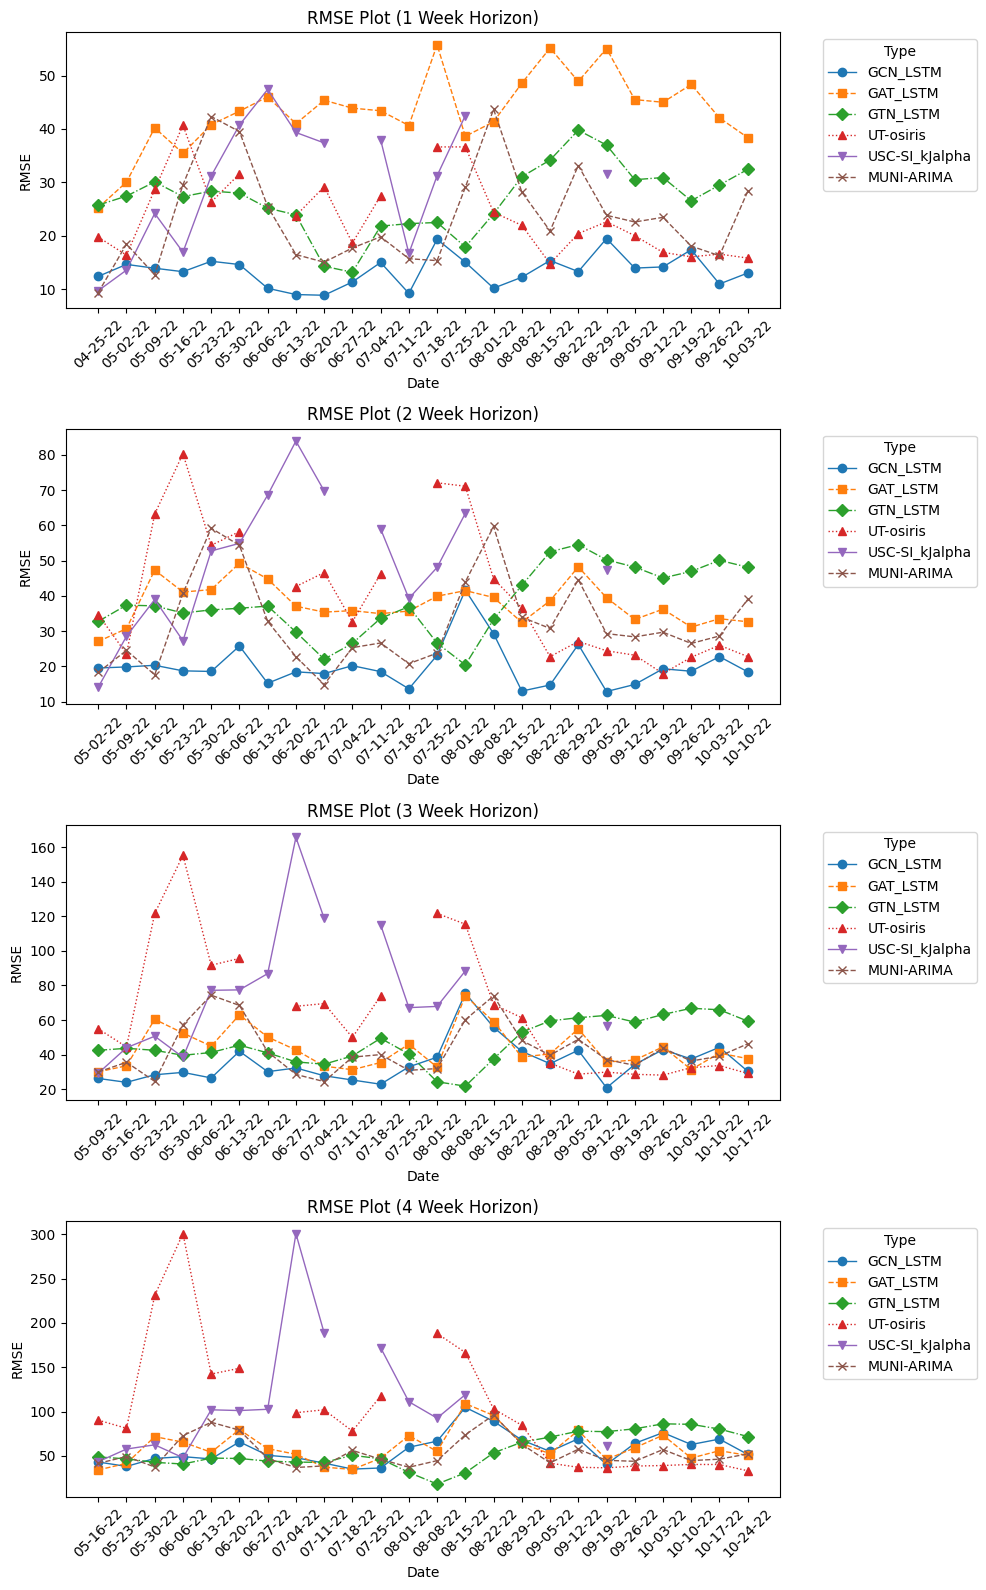

In [846]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize a DataFrame to store RMSE values along with week, horizon, and model type
rmse_data = []
total_weeks = y_pred_gtn.shape[0]
forecast_horizon = y_pred_gtn.shape[1]
num_states = y_pred_gtn.shape[2]

for horizon in range(forecast_horizon):
    for week in range(total_weeks):
        # Calculate and append RMSE for each model
        y_pred_gcn_lstm_rmse = np.sqrt(np.mean((y_pred_gcn_lstm[week, horizon, :] - y[week, horizon, :])**2))
        rmse_data.append({'Week': week, 'Horizon': horizon, 'Type': 'GCN_LSTM', 'RMSE': y_pred_gcn_lstm_rmse})

        y_pred_gat_lstm_rmse = np.sqrt(np.mean((y_pred_gat_lstm[week, horizon, :] - y[week, horizon, :])**2))
        rmse_data.append({'Week': week, 'Horizon': horizon, 'Type': 'GAT_LSTM', 'RMSE': y_pred_gat_lstm_rmse})

        y_pred_gtn_lstm_rmse = np.sqrt(np.mean((y_pred_gtn[week, horizon, :] - y[week, horizon, :])**2))
        rmse_data.append({'Week': week, 'Horizon': horizon, 'Type': 'GTN_LSTM', 'RMSE': y_pred_gtn_lstm_rmse})

        ut_rmse = np.sqrt(np.mean((UT[week, horizon, :] - y[week, horizon, :])**2))
        rmse_data.append({'Week': week, 'Horizon': horizon, 'Type': 'UT-osiris', 'RMSE': ut_rmse})

        usc_rmse = np.sqrt(np.mean((USC[week, horizon, :] - y[week, horizon, :])**2))
        rmse_data.append({'Week': week, 'Horizon': horizon, 'Type': 'USC-SI_kJalpha', 'RMSE': usc_rmse})

        muni_rmse = np.sqrt(np.mean((MUNI[week, horizon, :] - y[week, horizon, :])**2))
        rmse_data.append({'Week': week, 'Horizon': horizon, 'Type': 'MUNI-ARIMA', 'RMSE': muni_rmse})

# Convert to DataFrame
rmse_df = pd.DataFrame(rmse_data)

# Set up the start dates for each horizon
horizon_start_dates = ['2022-04-25', '2022-05-02', '2022-05-09', '2022-05-16' ]
week_dates_dict = {}

# Generate week dates for each horizon with week numbers
for horizon, start_date in enumerate(horizon_start_dates):
    start_date = pd.to_datetime(start_date)
    week_dates = [start_date + pd.to_timedelta(7 * w, unit='D') for w in range(total_weeks)]
    week_dates_str = [f'{date.strftime("%m-%d-%y")}' for week_num, date in enumerate(week_dates, start=1)]
    week_dates_dict[horizon] = week_dates_str

# Plotting the line plots with adjusted styles and colors
plt.figure(figsize=(10, 4 * forecast_horizon))
line_styles = ['-', '--', '-.', ':', '-', '--']  # Different line styles
markers = ['o', 's', 'D', '^', 'v', 'x']  # Different markers

for horizon in range(forecast_horizon):
    plt.subplot(forecast_horizon, 1, horizon + 1)
    for i, model in enumerate(rmse_df['Type'].unique()):
        model_data = rmse_df[(rmse_df['Horizon'] == horizon) & (rmse_df['Type'] == model)]
        plt.plot(model_data['Week'], model_data['RMSE'], label=model, linestyle=line_styles[i], marker=markers[i], linewidth=1)
    
    plt.xlabel("Date")
    plt.ylabel('RMSE')
    plt.title(f'RMSE Plot ({horizon + 1} Week Horizon)')
    plt.xticks(range(total_weeks), week_dates_dict[horizon], rotation=45)  # Set week number + date as x-axis labels
    plt.legend(title='Type', bbox_to_anchor=(1.05, 1), loc='upper left')  # Move legend outside the plot for better readability

plt.tight_layout()
plt.savefig("rmseplot_updated.png", dpi=600)
plt.show()


# Policy evaluation section will be evaluated based on best model that we select from mae, rmse comparison, so no need to run all the architecutres here


### Policy Evaluation
In this section we modify the policy values for specific date range and try to understand the impact of that specific policy change on the overall dynamics of the hospitalization accross all the states.

Policy Application: The function modifies the test data (x_test) according to specified policy changes for a given period (policy_start to policy_end).

Model Predictions: It makes predictions using the original and modified test data (y_pred and y_pred_policy).

Data Rescaling: Predictions and test data are rescaled back to their original scale using provided standard deviation (std) and mean (mean).

Impact Calculation: The function calculates the policy impact as the difference between predictions with and without the policy changes, both in absolute and percentage terms.

Confidence Intervals Calculation: For each state and forecast horizon, it computes the confidence intervals of the percentage impact using the t-distribution.

Aggregation: The script aggregates the upper and lower bounds of the confidence intervals across all states, calculating the average bounds for each forecast horizon.

Return Value: The function returns the confidence intervals for each state and forecast horizon.



In [847]:

def calculate_confidence_intervals(model, test_dataset, policy_start, policy_end, policy_changes,  std, mean):
    # Apply policy changes to x_test
    x_test, y = next(test_dataset.as_numpy_iterator())
    #x_test shape:(timestep, input_sequence_length, states, features, 1)
    y_pred = model.predict(x_test)

    x_test_policy = np.array(x_test.copy())
    #print(x_test_policy.shape)
    for change in policy_changes:
        x_test_policy[policy_start:policy_end, :, :, change[0]:change[1]] = change[2]

    # Predict with the modified x_test_policy
    y_pred_policy = model.predict(x_test_policy)

    # Rescale predictions if necessary

        # Assuming multivariate case here
        # Add your multivariate handling code
    x_test=x_test[:, :, :, 0]* std[:, 0] +mean[:, 0]
        #x_test_shape=(timestep, input_sequence_length, states)
    y=y*std[:, 0]+mean[:,0]
    y_pred=y_pred*std[:, 0]+mean[:,0]
    y_pred_policy=y_pred_policy*std[:, 0]+mean[:, 0]

    # Calculate policy impact
    policy_impact =  y_pred_policy[policy_start:policy_end, :, :]-y_pred[policy_start:policy_end, :, :]
    perc_policy_impact = (policy_impact / y_pred[policy_start:policy_end, :, :]) * 100

    # Confidence intervals calculation
    confidence_level = 0.95
    forecast_horizon = y.shape[1]
    num_states = y.shape[2]
    confidence_intervals = np.zeros((forecast_horizon, num_states, 2))
    mean_impacts = np.zeros((forecast_horizon, num_states))
    y_lim_max=[]
    y_lim_min=[]
    for state in range(num_states):
        max_upper_bound_for_state = float('-inf')
        min_upper_bound_for_state=float('+inf')
        for horizon in range(forecast_horizon):
            impacts = perc_policy_impact[:, horizon, state]
            degrees_freedom = len(impacts) - 1
            mean_impact = np.mean(impacts)
            std_err = np.std(impacts) / np.sqrt(len(impacts))

            lower, upper = stats.t.interval(confidence_level, degrees_freedom, mean_impact, std_err)
            if np.isnan(lower):
                lower = 0
            if np.isnan(upper):
                upper = 0

            confidence_intervals[horizon, state] = [lower, upper]
            mean_impacts[horizon, state] = mean_impact
            if upper> max_upper_bound_for_state:
                max_upper_bound_for_state=upper
            if lower< min_upper_bound_for_state:
                min_upper_bound_for_state=lower
        y_lim_max.append(max_upper_bound_for_state)
        y_lim_min.append(min_upper_bound_for_state)

    
    #fig, axes = plt.subplots(num_states, forecast_horizon, figsize=(15, 15))
    #print(confidence_intervals)
    #print (mean_impacts)

    for horizon in range(forecast_horizon):
        lower_bound_all=0
        upper_bound_all=0
        for state in range(num_states):
            #ax = axes[state, horizon]

            # Extract data for this horizon and state
            #no_policy = y_pred[policy_start:policy_end, horizon, state]
            #policy = y_pred_policy[policy_start:policy_end, horizon, state]
            lower_bounds, upper_bounds = confidence_intervals[horizon, state, :]
            lower_bound_all+=lower_bounds
            upper_bound_all+=upper_bounds
            #print("lower: ", lower_bounds, " upper: ", upper_bounds)

        print(f"lower_bound_all, {lower_bound_all/(len(state_list))}, upper_bound_all, {upper_bound_all/(len(state_list))}")
    
    return confidence_intervals

In [848]:
#changing policies

#no change
policy_changes1 = []  # Define policy changes here
confidence_intervals1 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes1, std, mean)

#judicial action against masking mandates and restaurent open
policy_changes2 = [ (1, 2, -2), (2, 3, 0)]
confidence_intervals2 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes2,  std, mean)

#criminal charge without masking and restaurent closed
policy_changes3 = [ (1, 2, 4), (2, 3, 1)]
confidence_intervals3 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes3,  std, mean)

#masking mandates in specific settings
policy_changes4 = [ (1, 2, 1)]
confidence_intervals4 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes4,  std, mean)


1/1 [==============================] - 0s 37ms/step
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
1/1 [==============================] - 0s 39ms/step


C:\Users\islam70\Anaconda3\envs\GCN_LSTM_Python3_8\lib\site-packages\scipy\stats\_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
C:\Users\islam70\Anaconda3\envs\GCN_LSTM_Python3_8\lib\site-packages\scipy\stats\_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


lower_bound_all, -3.0531813137850197, upper_bound_all, 0.37982962932078035
lower_bound_all, 0.6051441753687801, upper_bound_all, 4.904618895200085
lower_bound_all, 3.3624003858337743, upper_bound_all, 7.597625306050233
lower_bound_all, 7.119698392421385, upper_bound_all, 12.212035394657674
1/1 [==============================] - 0s 36ms/step
lower_bound_all, -9.061712763648723, upper_bound_all, -5.977652466991358
lower_bound_all, -15.700882208997973, upper_bound_all, -12.280139541322256
lower_bound_all, -21.218333488064108, upper_bound_all, -16.64575974728037
lower_bound_all, -28.472416277887845, upper_bound_all, -20.2307239332641
1/1 [==============================] - 0s 36ms/step
lower_bound_all, -4.674576127737879, upper_bound_all, -1.9286513839409103
lower_bound_all, -8.553912596927372, upper_bound_all, -5.253646672222225
lower_bound_all, -11.802297200686786, upper_bound_all, -8.045910142222182
lower_bound_all, -16.229798196177914, upper_bound_all, -10.781960007308506


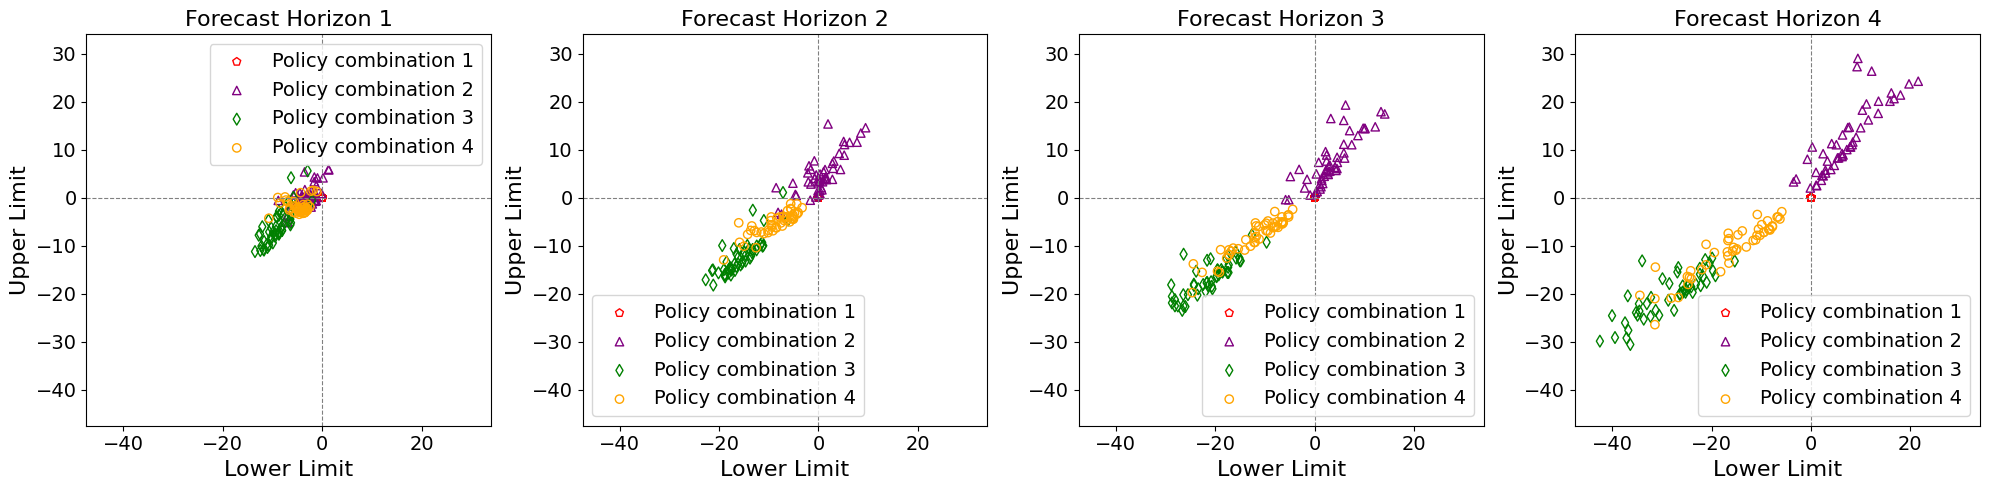

In [864]:
#plotting the changes

# Assuming confidence_intervals is a numpy array of shape (forecast_horizon, num_states, 2)
# Assuming confidence_intervals2 is the second array with the same shape


# Determine the global minimum and maximum for the x and y axes, considering both arrays
global_lower_min = min(np.min(confidence_intervals1[:, :, 0]), np.min(confidence_intervals2[:, :, 0]),
                      np.min(confidence_intervals3[:, :, 0]), np.min(confidence_intervals4[:, :, 0]))
global_upper_max = max(np.max(confidence_intervals1[:, :, 1]), np.max(confidence_intervals2[:, :, 1]),
                      np.max(confidence_intervals3[:, :, 1]), np.max(confidence_intervals4[:, :, 1]))

# Create a figure with 4 subplots (one for each forecast horizon)
fig, axs = plt.subplots(nrows=1, ncols=forecast_horizon, figsize=(20, 5))  # Adjust figsize as needed

# Define colors for the scatter plots
colors = ['red' , 'purple','green', 'orange']  # Modify as per your preference

# Iterate over each forecast horizon
for i in range(forecast_horizon):
    # Data from the first set of confidence intervals
    lower_limits1 = confidence_intervals1[i, :, 0]
    upper_limits1 = confidence_intervals1[i, :, 1]

    # Data from the second set of confidence intervals
    lower_limits2 = confidence_intervals2[i, :, 0]
    upper_limits2 = confidence_intervals2[i, :, 1]

    lower_limits3 = confidence_intervals3[i, :, 0]
    upper_limits3 = confidence_intervals3[i, :, 1]

    lower_limits4 = confidence_intervals4[i, :, 0]
    upper_limits4 = confidence_intervals4[i, :, 1]

    # Scatter plot for the first set of confidence intervals
    axs[i].scatter(lower_limits1, upper_limits1, color=colors[0], marker='p', facecolors='none', label='Policy combination 1')

    # Scatter plot for the second set of confidence intervals
    axs[i].scatter(lower_limits2, upper_limits2, color=colors[1], marker='^',facecolors='none',label='Policy combination 2')

    axs[i].scatter(lower_limits3, upper_limits3, color=colors[2],marker='d', facecolors='none', label='Policy combination 3')

    # Scatter plot for the second set of confidence intervals
    axs[i].scatter(lower_limits4, upper_limits4, color=colors[3], marker='o',facecolors='none',label='Policy combination 4')


    axs[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.8)

    # Set titles and labels
    axs[i].set_title(f'Forecast Horizon {i+1}', fontsize=16)
    axs[i].set_xlabel('Lower Limit', fontsize=16)
    axs[i].set_ylabel('Upper Limit', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Set the same x and y limits for all subplots
    axs[i].set_xlim(global_lower_min-5, global_upper_max+5)
    axs[i].set_ylim(global_lower_min-5, global_upper_max+5)

    # Enable grid and legend
    #axs[i].grid(True)
    axs[i].legend()
    axs[i].legend(fontsize=14)


# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('policy combination 1_2_3_4.png', dpi=600)
plt.show()


In [850]:
#no change
policy_changes1 = []  # Define policy changes here
confidence_intervals1 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes1, std, mean)

#criminal charge without masking
policy_changes5 = [ (1, 2, 4)]
confidence_intervals5 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes5, std, mean)

#restaurent closed
policy_changes6 = [ (2, 3, 1)]
confidence_intervals6 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes6,  std, mean)

#mandates that don't have any enforcement measures
policy_changes7 = [ (1, 2, 2)]
confidence_intervals7 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes7,std, mean)



1/1 [==============================] - 0s 38ms/step
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
1/1 [==============================] - 0s 37ms/step
lower_bound_all, -3.0369847557887852, upper_bound_all, 1.1028427631738424
lower_bound_all, -9.366161204664389, upper_bound_all, -5.79971715661084
lower_bound_all, -14.279772616397475, upper_bound_all, -11.04495018807974
lower_bound_all, -21.73531623615801, upper_bound_all, -15.671060900051986
1/1 [==============================] - 0s 38ms/step
lower_bound_all, -15.809628669270467, upper_bound_all, -13.225371348348858
lower_bound_all, -22.14183726517903, upper_bound_all, -19.60492409113702
lower_bound_all, -25.35437792296455, upper_bound_all, -22.579037246709984
lower_bound_all, -28.438689338367755, upper_bound_all, -23.810554958940543
1/1 [==============================] - 0s 37ms/step
lower_bound_all, -6.026917804

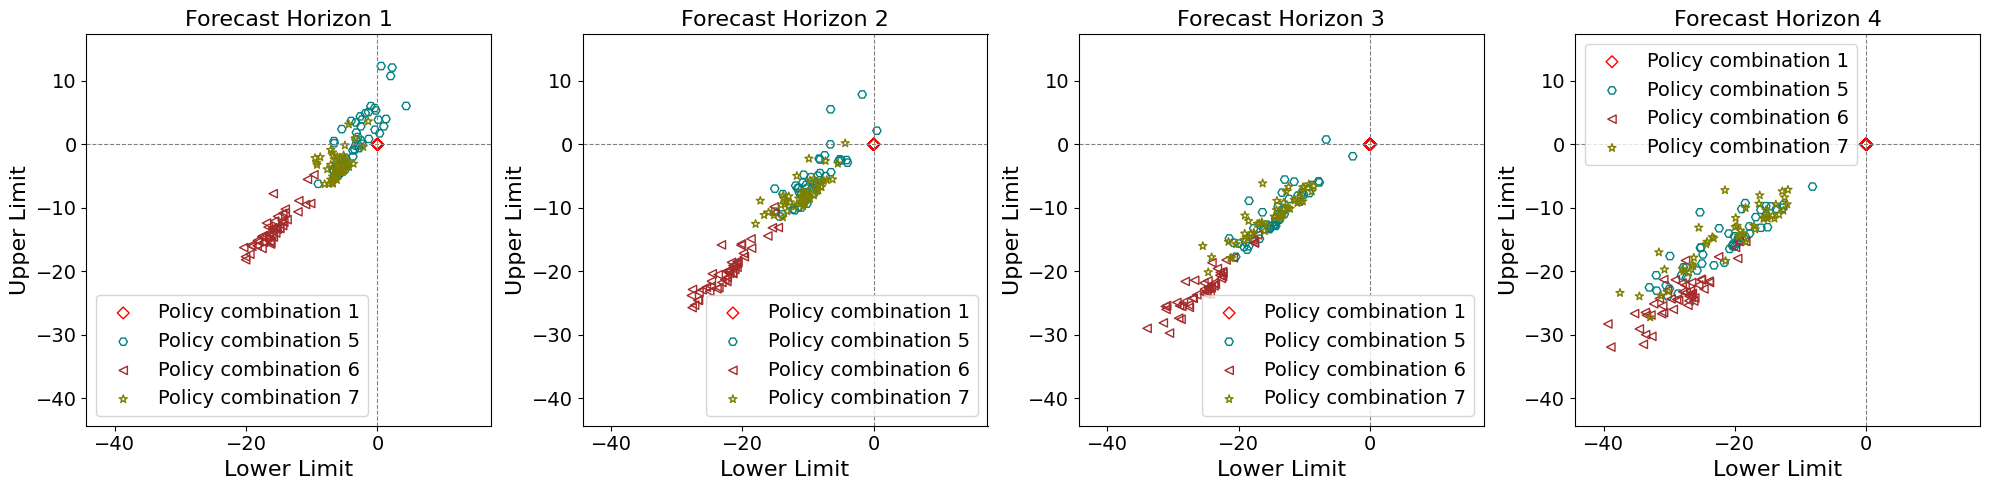

In [865]:
#plotting the changes


# Determine the global minimum and maximum for the x and y axes, considering both arrays
global_lower_min = min(np.min(confidence_intervals1[:, :, 0]), np.min(confidence_intervals5[:, :, 0]),
                      np.min(confidence_intervals6[:, :, 0]), np.min(confidence_intervals7[:, :, 0]))
global_upper_max = max(np.max(confidence_intervals1[:, :, 1]), np.max(confidence_intervals5[:, :, 1]),
                      np.max(confidence_intervals6[:, :, 1]),  np.max(confidence_intervals7[:, :, 1]))

# Create a figure with 4 subplots (one for each forecast horizon)
fig, axs = plt.subplots(nrows=1, ncols=forecast_horizon, figsize=(20, 5))  # Adjust figsize as needed

# Define colors for the scatter plots
colors = ['red' , 'teal','brown', 'olive']  # Modify as per your preference

# Iterate over each forecast horizon
for i in range(forecast_horizon):
    # Data from the first set of confidence intervals
    lower_limits1 = confidence_intervals1[i, :, 0]
    upper_limits1 = confidence_intervals1[i, :, 1]

    # Data from the second set of confidence intervals
    lower_limits5 = confidence_intervals5[i, :, 0]
    upper_limits5 = confidence_intervals5[i, :, 1]

    lower_limits6 = confidence_intervals6[i, :, 0]
    upper_limits6 = confidence_intervals6[i, :, 1]

    lower_limits7 = confidence_intervals7[i, :, 0]
    upper_limits7 = confidence_intervals7[i, :, 1]
    # Scatter plot for the first set of confidence intervals
    axs[i].scatter(lower_limits1, upper_limits1, color=colors[0], marker='D', facecolors='none', label='Policy combination 1')

    # Scatter plot for the second set of confidence intervals
    axs[i].scatter(lower_limits5, upper_limits5, color=colors[1], marker='H',facecolors='none',label='Policy combination 5')

    axs[i].scatter(lower_limits6, upper_limits6, color=colors[2],marker='<', facecolors='none', label='Policy combination 6')

    axs[i].scatter(lower_limits7, upper_limits7, color=colors[3],marker='*', facecolors='none', label='Policy combination 7')


    axs[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.8)

    # Set titles and labels
    axs[i].set_title(f'Forecast Horizon {i+1}', fontsize=16)
    
    axs[i].set_xlabel('Lower Limit', fontsize=16)
    axs[i].set_ylabel('Upper Limit', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Set the same x and y limits for all subplots
    axs[i].set_xlim(global_lower_min-5, global_upper_max+5)
    axs[i].set_ylim(global_lower_min-5, global_upper_max+5)

    # Enable grid and legend
    #axs[i].grid(True)
    axs[i].legend()
    axs[i].legend(fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('policy combination 1_5_6_7.png', dpi=600)
plt.show()


In [852]:
#no change
policy_changes1 = []  # Define policy changes here
confidence_intervals1 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes1, std, mean)

#criminal charge without masking and restaurent closed
policy_changes3 = [ (1, 2, 4), (2, 3, 1)]
confidence_intervals3 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes3, std, mean)

#mandates without enforcement and restaurent closed
policy_changes8 = [ (1, 2, 2) , (2, 3, 1)]
confidence_intervals8 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes8,  std, mean)



1/1 [==============================] - 0s 36ms/step
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
1/1 [==============================] - 0s 36ms/step
lower_bound_all, -9.061712763648723, upper_bound_all, -5.977652466991358
lower_bound_all, -15.700882208997973, upper_bound_all, -12.280139541322256
lower_bound_all, -21.218333488064108, upper_bound_all, -16.64575974728037
lower_bound_all, -28.472416277887845, upper_bound_all, -20.2307239332641
1/1 [==============================] - 0s 36ms/step
lower_bound_all, -12.163622897484295, upper_bound_all, -8.982271156200218
lower_bound_all, -18.661762059887646, upper_bound_all, -14.85283465799146
lower_bound_all, -23.765534030321117, upper_bound_all, -18.968291237576246
lower_bound_all, -29.82851893849664, upper_bound_all, -21.885123533910175


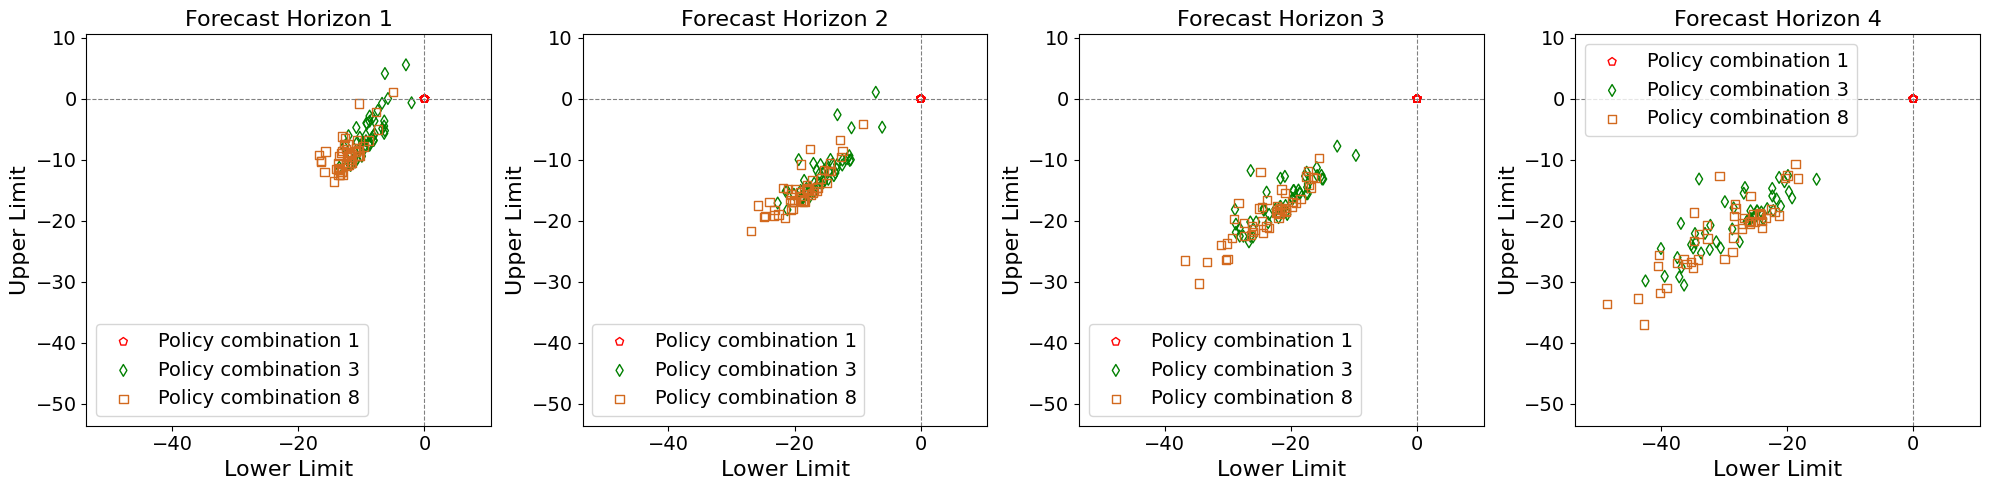

In [866]:
#plotting the changes

# Determine the global minimum and maximum for the x and y axes, considering both arrays
global_lower_min = min(np.min(confidence_intervals1[:, :, 0]),
                      np.min(confidence_intervals3[:, :, 0]), np.min(confidence_intervals8[:, :, 0]))
global_upper_max = max(np.max(confidence_intervals1[:, :, 1]),
                      np.max(confidence_intervals3[:, :, 1]), np.max(confidence_intervals8[:, :, 1]))

# Create a figure with 4 subplots (one for each forecast horizon)
fig, axs = plt.subplots(nrows=1, ncols=forecast_horizon, figsize=(20, 5))  # Adjust figsize as needed

# Define colors for the scatter plots
colors = ['red' , 'green', 'chocolate']  # Modify as per your preference

# Iterate over each forecast horizon
for i in range(forecast_horizon):
    # Data from the first set of confidence intervals
    lower_limits1 = confidence_intervals1[i, :, 0]
    upper_limits1 = confidence_intervals1[i, :, 1]


    lower_limits3 = confidence_intervals3[i, :, 0]
    upper_limits3 = confidence_intervals3[i, :, 1]

    lower_limits8 = confidence_intervals8[i, :, 0]
    upper_limits8 = confidence_intervals8[i, :, 1]

    # Scatter plot for the first set of confidence intervals
    axs[i].scatter(lower_limits1, upper_limits1, color=colors[0], marker='p', facecolors='none', label='Policy combination 1')


    axs[i].scatter(lower_limits3, upper_limits3, color=colors[1],marker='d', facecolors='none', label='Policy combination 3')

    # Scatter plot for the second set of confidence intervals
    axs[i].scatter(lower_limits8, upper_limits8, color=colors[2], marker='s',facecolors='none',label='Policy combination 8')


    axs[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.8)

    # Set titles and labels
    axs[i].set_title(f'Forecast Horizon {i+1}', fontsize=16)
    axs[i].set_xlabel('Lower Limit', fontsize=16)
    axs[i].set_ylabel('Upper Limit', fontsize=16)
    axs[i].tick_params(axis='both', which='major', labelsize=14)

    # Set the same x and y limits for all subplots
    axs[i].set_xlim(global_lower_min-5, global_upper_max+5)
    axs[i].set_ylim(global_lower_min-5, global_upper_max+5)

    # Enable grid and legend
    #axs[i].grid(True)
    axs[i].legend()
    axs[i].legend(fontsize=14)

# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('policy combination 1_3_8.png', dpi=600)
plt.show()


In [854]:
#modifying the code for changing the policy for some specific states

def calculate_confidence_intervals_states(model, test_dataset, policy_start, policy_end, policy_changes,  std, mean, state):
    # Apply policy changes to x_test
    x_test, y = next(test_dataset.as_numpy_iterator())
    #x_test shape:(timestep, input_sequence_length, states, features, 1)
    y_pred = model.predict(x_test)

    x_test_policy = np.array(x_test.copy())
    #print(x_test_policy.shape)

    for state in states_to_change:
        for change in policy_changes:
            x_test_policy[policy_start:policy_end, :, state, change[0]:change[1]] = change[2]

    # Predict with the modified x_test_policy
    y_pred_policy = model.predict(x_test_policy)

    # Rescale predictions if necessary

        # Assuming multivariate case here
        # Add your multivariate handling code
    x_test=x_test[:, :, :, 0]* std[:, 0] +mean[:, 0]
        #x_test_shape=(timestep, input_sequence_length, states)
    y=y*std[:, 0]+mean[:,0]
    y_pred=y_pred*std[:, 0]+mean[:,0]
    y_pred_policy=y_pred_policy*std[:, 0]+mean[:, 0]

    # Calculate policy impact
    policy_impact =  y_pred_policy[policy_start:policy_end, :, :]-y_pred[policy_start:policy_end, :, :]
    perc_policy_impact = (policy_impact / y_pred[policy_start:policy_end, :, :]) * 100

    # Confidence intervals calculation
    confidence_level = 0.95
    forecast_horizon = y.shape[1]
    num_states = y.shape[2]
    confidence_intervals = np.zeros((forecast_horizon, num_states, 2))
    mean_impacts = np.zeros((forecast_horizon, num_states))
    y_lim_max=[]
    y_lim_min=[]
    for state in range(num_states):
        max_upper_bound_for_state = float('-inf')
        min_upper_bound_for_state=float('+inf')
        for horizon in range(forecast_horizon):
            impacts = perc_policy_impact[:, horizon, state]
            degrees_freedom = len(impacts) - 1
            mean_impact = np.mean(impacts)
            std_err = np.std(impacts) / np.sqrt(len(impacts))

            lower, upper = stats.t.interval(confidence_level, degrees_freedom, mean_impact, std_err)
            if np.isnan(lower):
                lower = 0
            if np.isnan(upper):
                upper = 0

            confidence_intervals[horizon, state] = [lower, upper]
            mean_impacts[horizon, state] = mean_impact
            if upper> max_upper_bound_for_state:
                max_upper_bound_for_state=upper
            if lower< min_upper_bound_for_state:
                min_upper_bound_for_state=lower
        y_lim_max.append(max_upper_bound_for_state)
        y_lim_min.append(min_upper_bound_for_state)
    
    #fig, axes = plt.subplots(num_states, forecast_horizon, figsize=(15, 15))
    #print(confidence_intervals)
    
    #print (mean_impacts)

    for horizon in range(forecast_horizon):
        lower_bound_all=0
        upper_bound_all=0
        for state in range(num_states):
            #ax = axes[state, horizon]

            # Extract data for this horizon and state
            #no_policy = y_pred[policy_start:policy_end, horizon, state]
            #policy = y_pred_policy[policy_start:policy_end, horizon, state]
            lower_bounds, upper_bounds = confidence_intervals[horizon, state, :]
            lower_bound_all+=lower_bounds
            upper_bound_all+=upper_bounds
            #print("lower: ", lower_bounds, " upper: ", upper_bounds)

        print(f"lower_bound_all, {lower_bound_all/(len(state_list))}, upper_bound_all, {upper_bound_all/(len(state_list))}")
    
    return confidence_intervals

# Example usage


In [855]:
#no change
policy_changes1 = []  # Define policy changes here
confidence_intervals1 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes1, std, mean)


#criminal charge without masking and restaurent closed
policy_changes3 = [ (1, 2, 4), (2, 3, 1)]
confidence_intervals3 = calculate_confidence_intervals(gcn_lstm_model, test_dataset, 12, 22, policy_changes3, std, mean)

states_to_change = [3, 40, 7, 31, 35, 11, 32, 8]
#CA, TX, FL, NY, PA, IL, OH, GA
#criminal charge without masking and restaurent closed
policy_changes9 = [ (1, 2, 4), (2, 3, 1)]
confidence_intervals9 = calculate_confidence_intervals_states(gcn_lstm_model, test_dataset, 12, 22, policy_changes9,  std, mean, states_to_change)



1/1 [==============================] - 0s 36ms/step
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
lower_bound_all, 0.0, upper_bound_all, 0.0
1/1 [==============================] - 0s 36ms/step
lower_bound_all, -9.061712763648723, upper_bound_all, -5.977652466991358
lower_bound_all, -15.700882208997973, upper_bound_all, -12.280139541322256
lower_bound_all, -21.218333488064108, upper_bound_all, -16.64575974728037
lower_bound_all, -28.472416277887845, upper_bound_all, -20.2307239332641
1/1 [==============================] - 0s 38ms/step
lower_bound_all, -5.616992576053176, upper_bound_all, -4.127306082290508
lower_bound_all, -8.550262812898927, upper_bound_all, -6.4969222795695885
lower_bound_all, -10.517508404167838, upper_bound_all, -7.7306928026420465
lower_bound_all, -12.717035215476791, upper_bound_all, -8.879782805797673


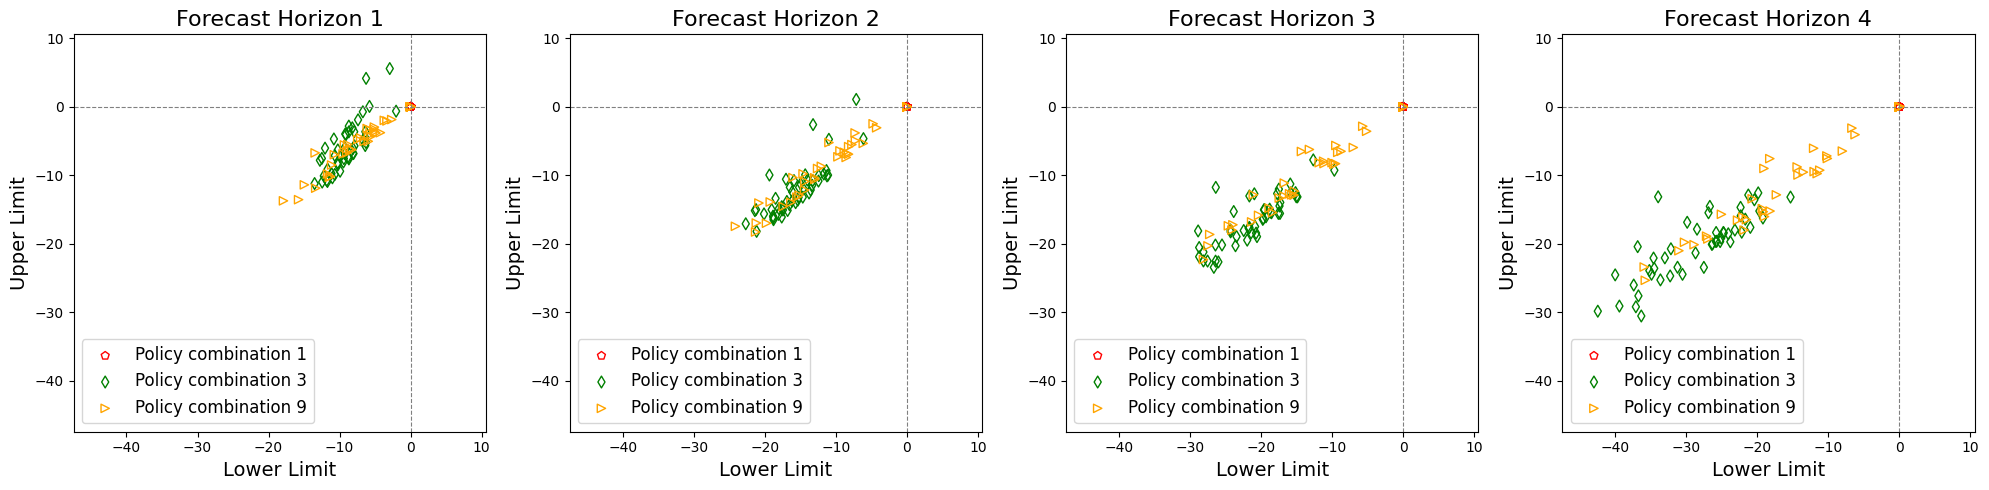

In [856]:
#plotting the changes

# Determine the global minimum and maximum for the x and y axes, considering both arrays
global_lower_min = min(np.min(confidence_intervals1[:, :, 0]), np.min(confidence_intervals3[:, :, 0]),
                      np.min(confidence_intervals9[:, :, 0]))
global_upper_max = max(np.max(confidence_intervals1[:, :, 1]), np.max(confidence_intervals3[:, :, 1]),
                      np.max(confidence_intervals9[:, :, 1]))

# Create a figure with 4 subplots (one for each forecast horizon)
fig, axs = plt.subplots(nrows=1, ncols=forecast_horizon, figsize=(20, 5))  # Adjust figsize as needed

# Define colors for the scatter plots
colors = ['red' , 'green', 'orange']  # Modify as per your preference

# Iterate over each forecast horizon
for i in range(forecast_horizon):
    # Data from the first set of confidence intervals
    lower_limits1 = confidence_intervals1[i, :, 0]
    upper_limits1 = confidence_intervals1[i, :, 1]

    lower_limits3 = confidence_intervals3[i, :, 0]
    upper_limits3 = confidence_intervals3[i, :, 1]

    lower_limits9 = confidence_intervals9[i, :, 0]
    upper_limits9 = confidence_intervals9[i, :, 1]


    # Scatter plot for the first set of confidence intervals
    axs[i].scatter(lower_limits1, upper_limits1, color=colors[0], marker='p', facecolors='none', label='Policy combination 1')


    axs[i].scatter(lower_limits3, upper_limits3, color=colors[1],marker='d', facecolors='none', label='Policy combination 3')

    axs[i].scatter(lower_limits9, upper_limits9, color=colors[2],marker='>', facecolors='none', label='Policy combination 9')

    axs[i].axhline(y=0, color='gray', linestyle='--', linewidth=0.8)
    axs[i].axvline(x=0, color='gray', linestyle='--', linewidth=0.8)

    # Set titles and labels
    axs[i].set_title(f'Forecast Horizon {i+1}', fontsize=16)
    axs[i].set_xlabel('Lower Limit', fontsize=14)
    axs[i].set_ylabel('Upper Limit', fontsize=14)
    #axs[i].
    # Set the same x and y limits for all subplots
    axs[i].set_xlim(global_lower_min-5, global_upper_max+5)
    axs[i].set_ylim(global_lower_min-5, global_upper_max+5)

    # Enable grid and legend
    #axs[i].grid(True)
    axs[i].legend()
    axs[i].legend(fontsize=12)



# Adjust layout and show the plot
plt.tight_layout()
plt.savefig('policy combination 1_3_9.png', dpi=600)
plt.show()
